## Setup & Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import warnings

In [3]:
sys.path.append(os.path.abspath('..'))

import src.config as cfg
from src.preprocessing import DataPreprocessor
from src.encoders import GlobalEncoder
from src.segmentation import SegmentManager
from src.modeling import ModelTrainer
from src.evaluation import ModelEvaluator
from src.interpretation import ShapAnalyzer
from src.deploy import ModelDeployer

C:\Users\Admin\Desktop\Segmented-Drivers-of-Airline-Satisfaction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Data Loading

In [5]:
print(f"Loading data from: {cfg.DATA_PATH}")

Loading data from: dataset/


In [6]:
df_train = pd.read_csv(os.path.join('..', cfg.DATA_PATH, cfg.TRAIN_FILE))
df_test = pd.read_csv(os.path.join('..', cfg.DATA_PATH, cfg.TEST_FILE))

In [7]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")

Train shape: (103904, 25)
Test shape:  (25976, 25)


In [8]:
df_train.head(3)

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
0               5                3             5                       5   
1               1                3             1                       1   
2               5                5             5                       5   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied

## Global Preprocessing

In [9]:
dp = DataPreprocessor()

In [10]:
cfg.ID_COLS

['Unnamed: 0', 'id']

In [11]:
df_train = dp.drop_columns(df_train, cfg.ID_COLS)
df_test = dp.drop_columns(df_test, cfg.ID_COLS)

Dropped columns: ['Unnamed: 0', 'id']
Dropped columns: ['Unnamed: 0', 'id']


In [12]:
cfg.DELAY_INPUT_COLS

['Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [13]:
df_train = dp.fill_na(df_train, cfg.DELAY_INPUT_COLS, value=0)
df_test = dp.fill_na(df_test, cfg.DELAY_INPUT_COLS, value=0)

Filled NaNs with 0 in 1 columns.
Filled NaNs with 0 in 1 columns.


In [14]:
# df_train = dp.transform_log_sum(df_train, cfg.DELAY_INPUT_COLS, cfg.DELAY_OUTPUT_COL, drop_input=True)
# df_test = dp.transform_log_sum(df_test, cfg.DELAY_INPUT_COLS, cfg.DELAY_OUTPUT_COL, drop_input=True)

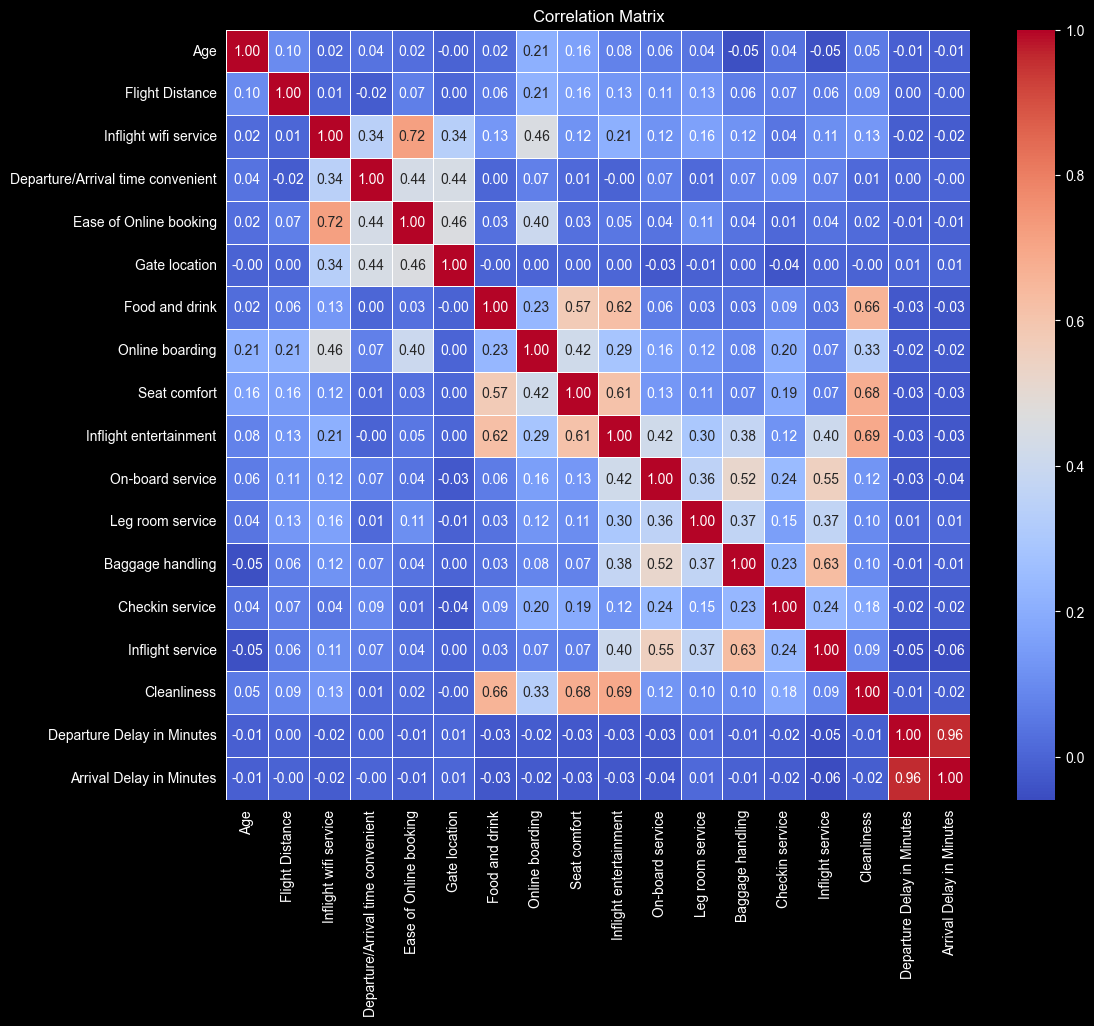

In [15]:
dp.plot_correlation(df_train)

In [16]:
df_train = dp.create_feature(df_train,
                             output_col='Arrival Delay Log',
                             func=lambda df: np.log1p(1 + df['Arrival Delay in Minutes']))
df_test = dp.create_feature(df_test,
                             output_col='Arrival Delay Log',
                             func=lambda df: np.log1p(1 + df['Arrival Delay in Minutes']))

Feature created: 'Arrival Delay Log'
Feature created: 'Arrival Delay Log'


In [17]:
df_train = dp.create_feature(df_train,
                             output_col='Time Saved In Air',
                             func=lambda df: df['Departure Delay in Minutes'] - df['Arrival Delay in Minutes'])
df_test = dp.create_feature(df_test,
                             output_col='Time Saved In Air',
                             func=lambda df: df['Departure Delay in Minutes'] - df['Arrival Delay in Minutes'])

Feature created: 'Time Saved In Air'
Feature created: 'Time Saved In Air'


In [18]:
df_train = dp.drop_columns(df_train, ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])
df_test = dp.drop_columns(df_test, ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])

Dropped columns: ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
Dropped columns: ['Departure Delay in Minutes', 'Arrival Delay in Minutes']


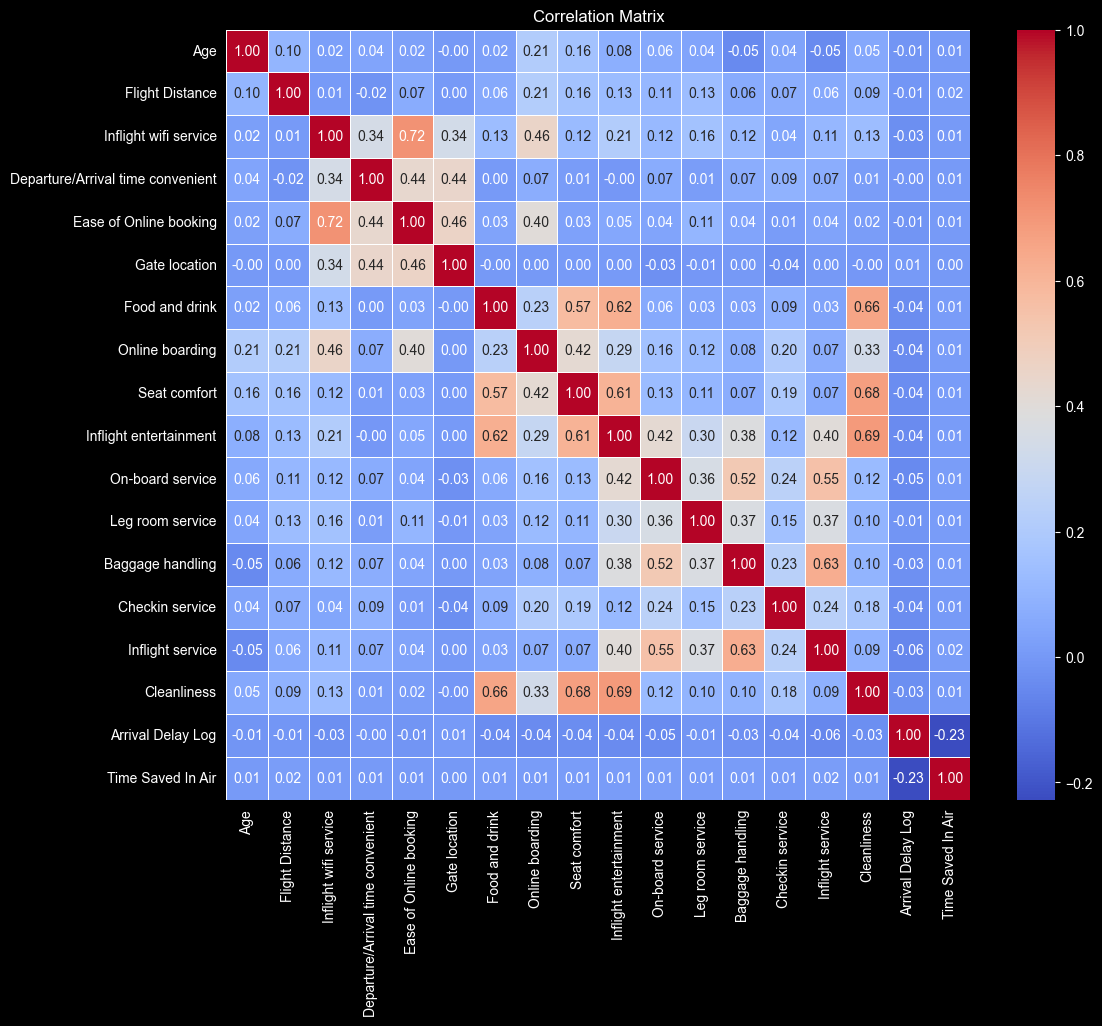

In [19]:
dp.plot_correlation(df_train)

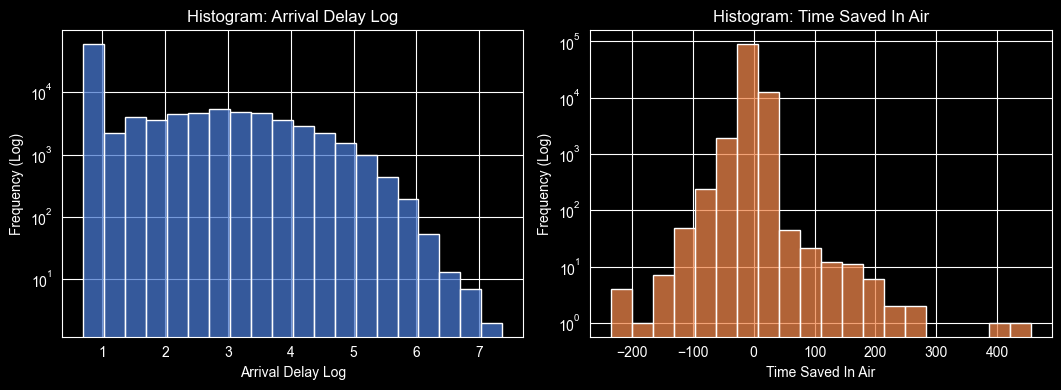

In [20]:
dp.plot_histograms(df_train, ['Arrival Delay Log', 'Time Saved In Air'], log_y=True)

In [21]:
cfg.SERVICE_COLS

['Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness']

In [22]:
zero_stats = dp.analyze_zeros(df_train, columns=cfg.SERVICE_COLS)


=== Zero Values Analysis ===
                                   Zeros Count  Zeros %
Departure/Arrival time convenient         5300     5.10
Ease of Online booking                    4487     4.32
Inflight wifi service                     3103     2.99
Online boarding                           2428     2.34
Leg room service                           472     0.45
Food and drink                             107     0.10
Inflight entertainment                      14     0.01
Cleanliness                                 12     0.01
Gate location                                1     0.00
Seat comfort                                 1     0.00
On-board service                             3     0.00
Checkin service                              1     0.00
Inflight service                             3     0.00

Total columns checked: 14


Cleaning noise (rows with invalid zeros)

In [23]:
columns_to_drop = ['Inflight entertainment',
                   'Food and drink',
                   'Cleanliness',
                   'Gate location',
                   'Seat comfort',
                   'On-board service',
                   'Checkin service',
                   'Inflight service']

In [24]:
df_train = dp.drop_rows_with_by_value(df_train, columns=columns_to_drop, drop_value=0)
df_test = dp.drop_rows_with_by_value(df_test, columns=columns_to_drop, drop_value=0)

Dropped 112 rows (0.11%) containing 0s.
Dropped 27 rows (0.10%) containing 0s.


In [25]:
columns_to_replace_zeros = [col for col in cfg.SERVICE_COLS if not col in columns_to_drop ]
columns_to_replace_zeros

['Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Online boarding',
 'Leg room service',
 'Baggage handling']

In [26]:
df_train = dp.replace_values(df_train,
                             columns_to_replace_zeros,
                             old_value=0,
                             new_value=np.nan)
df_test = dp.replace_values(df_test,
                            columns_to_replace_zeros,
                            old_value=0,
                            new_value=np.nan)

Replaced '0' with 'nan' in 5 columns.
Replaced '0' with 'nan' in 5 columns.


## Visualizing the need for segmentation

### Type of Travel

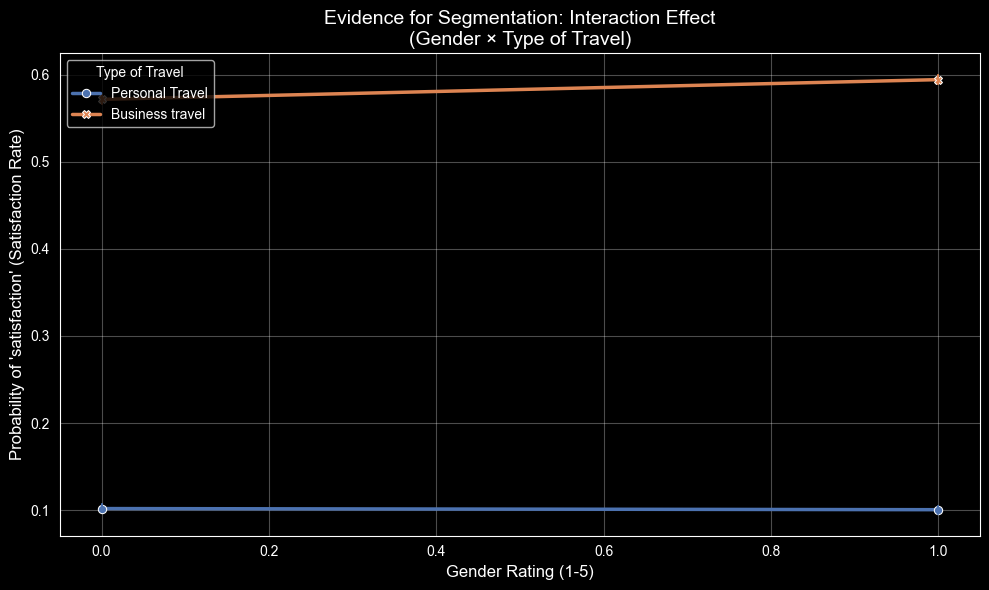

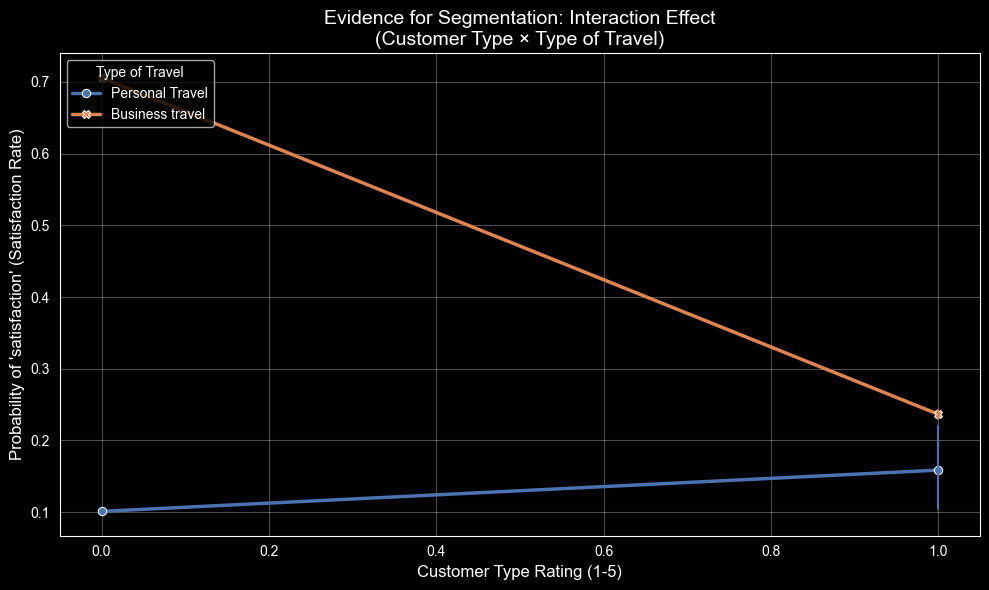

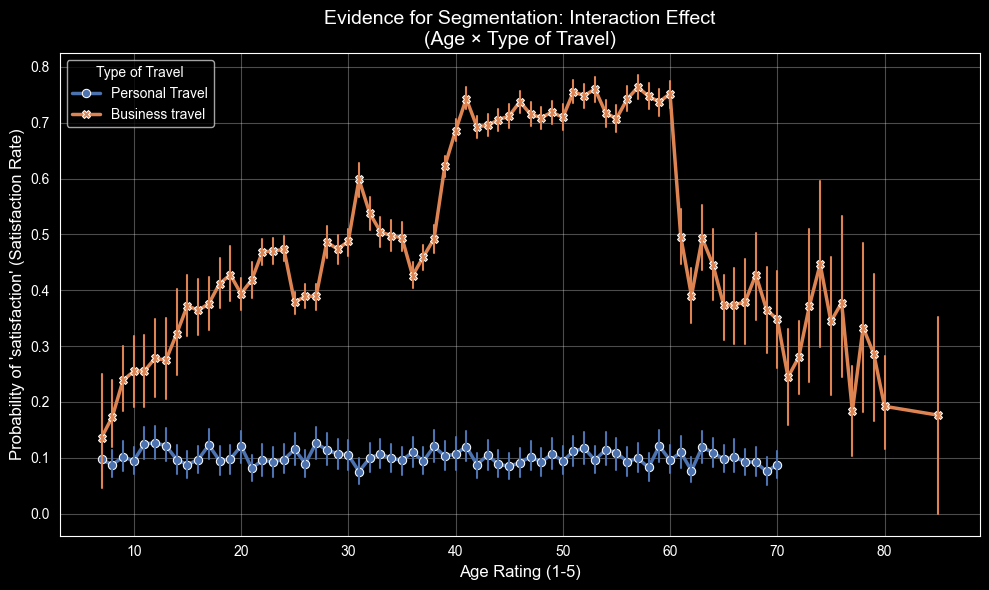

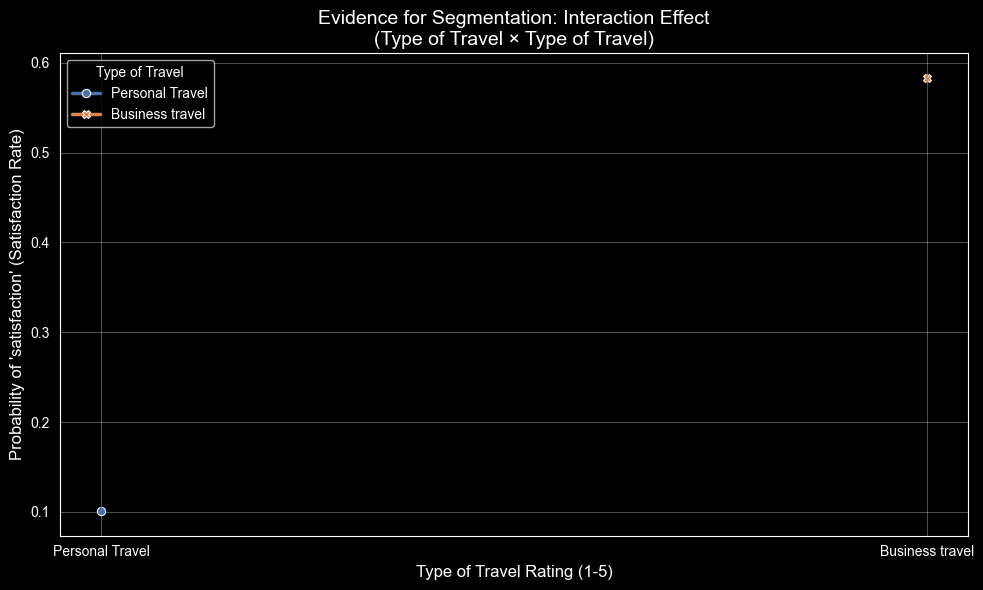

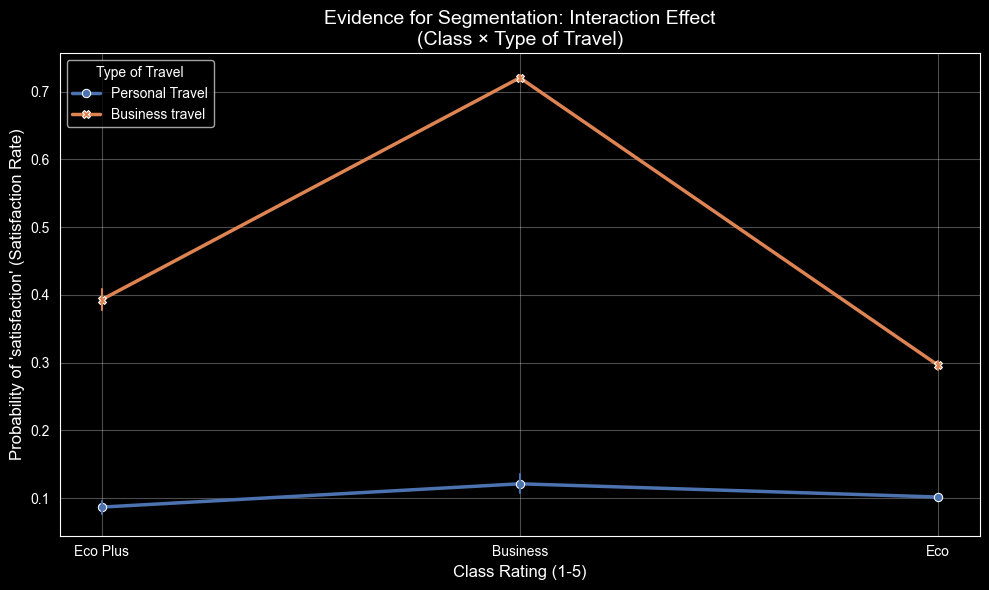

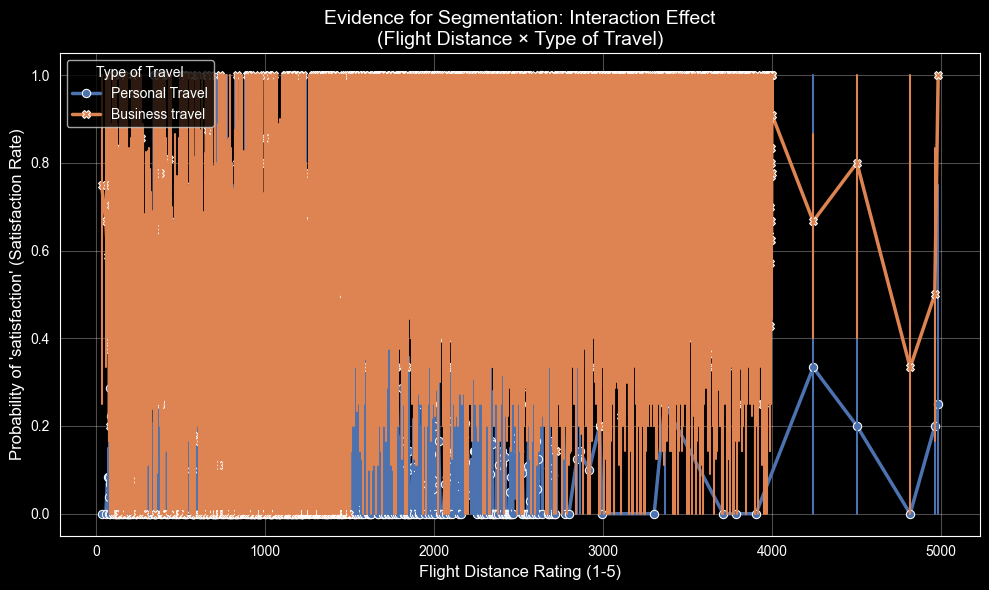

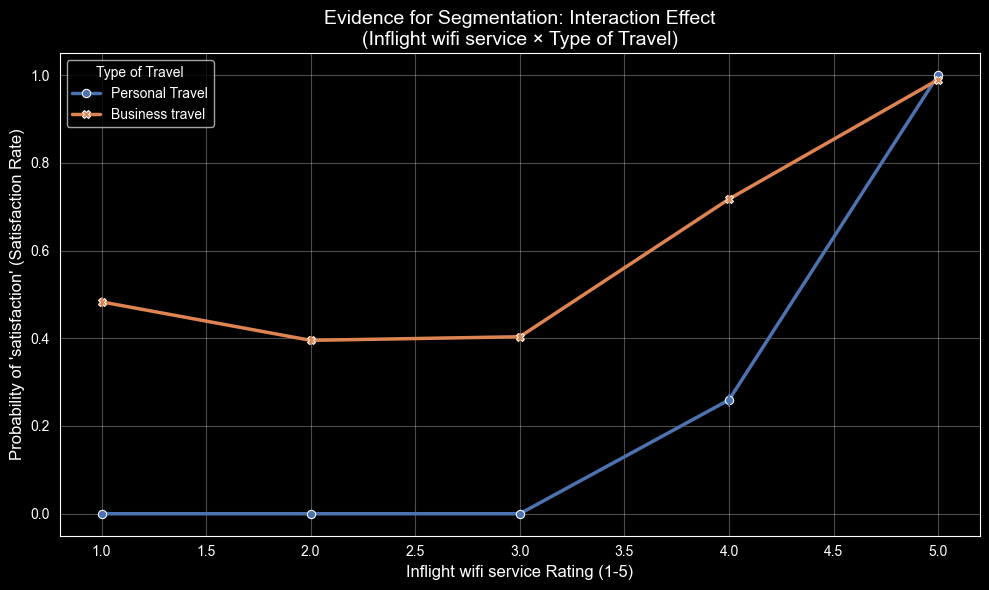

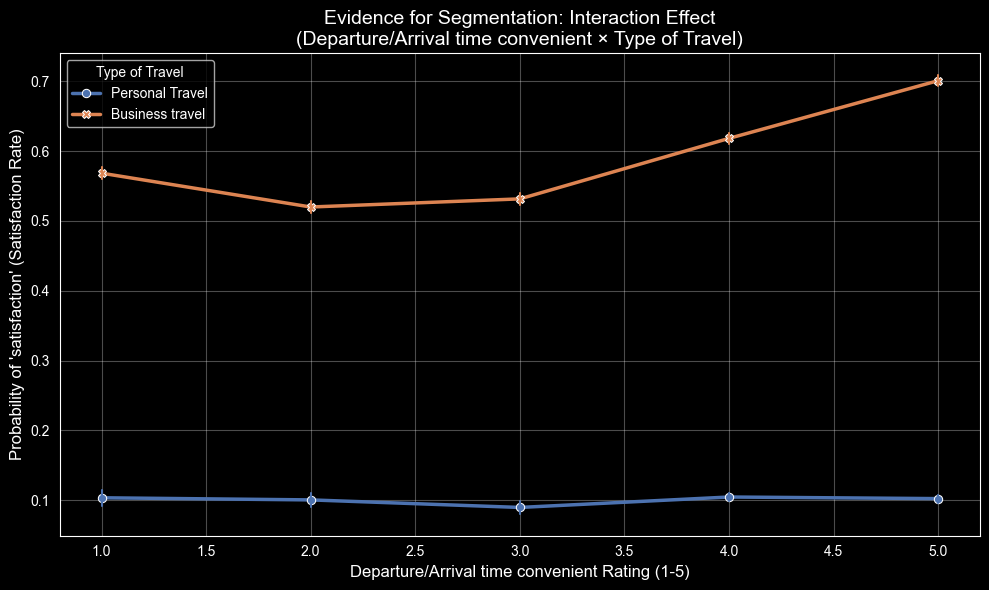

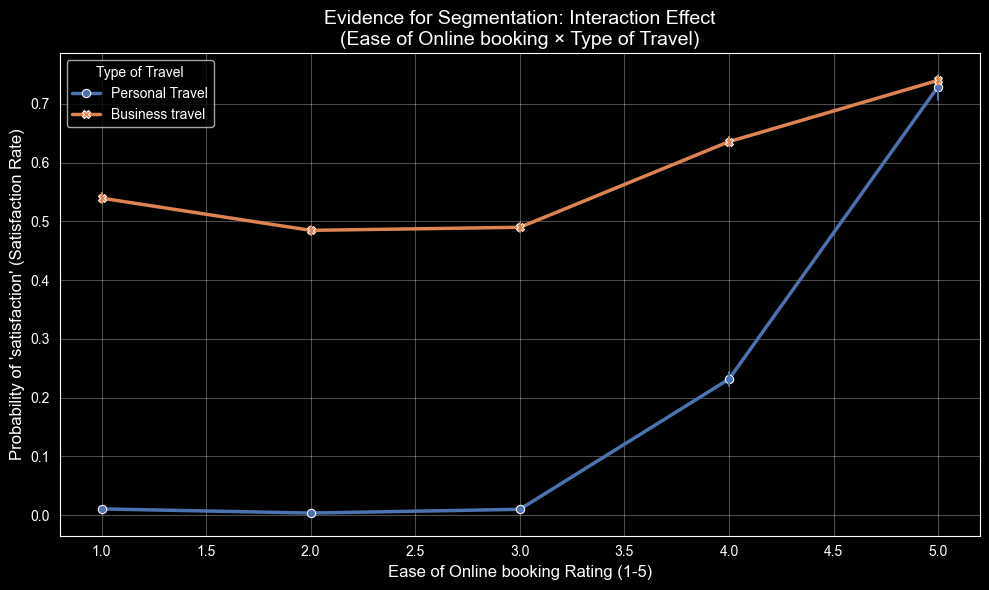

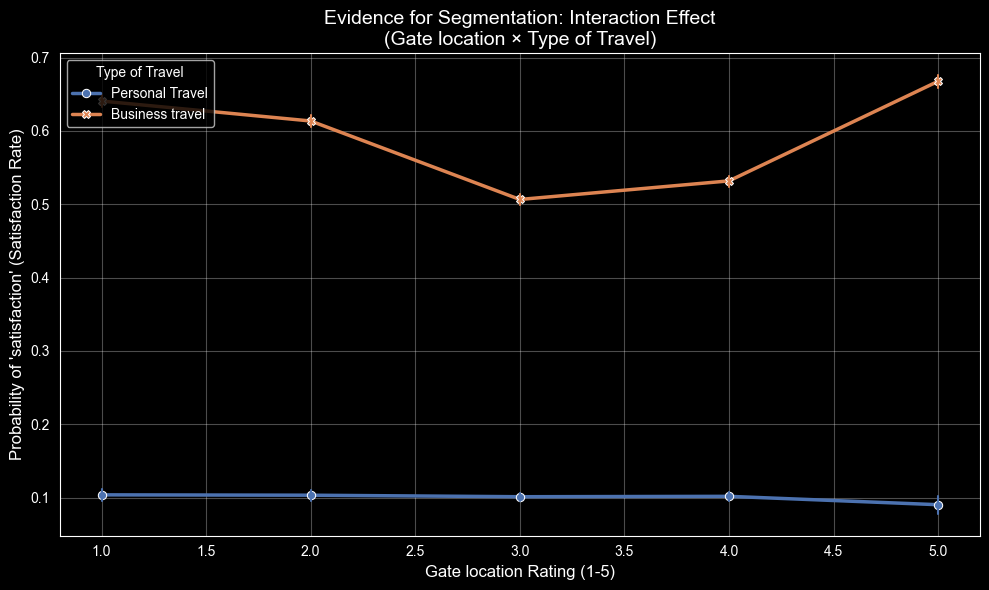

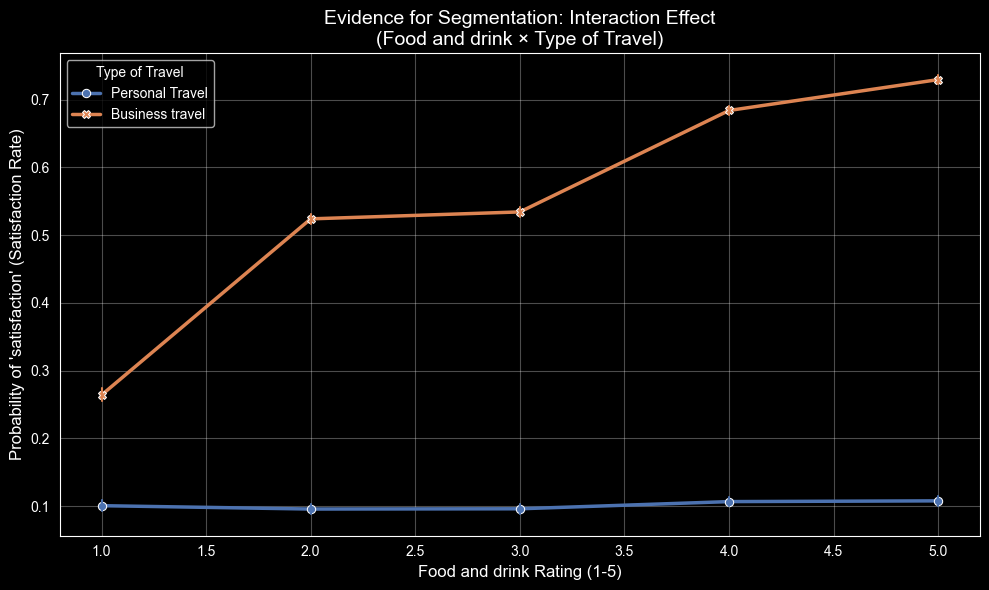

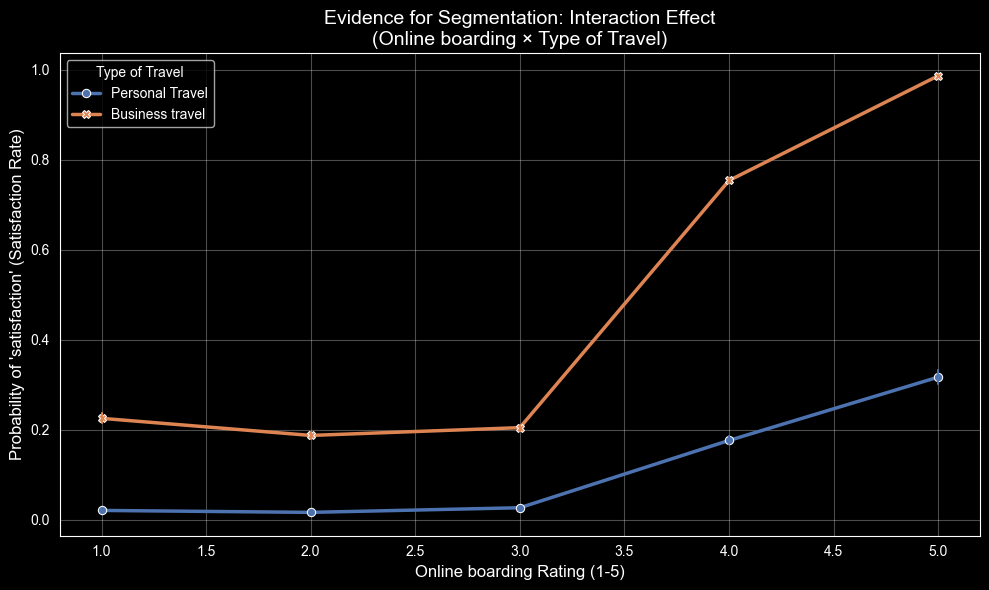

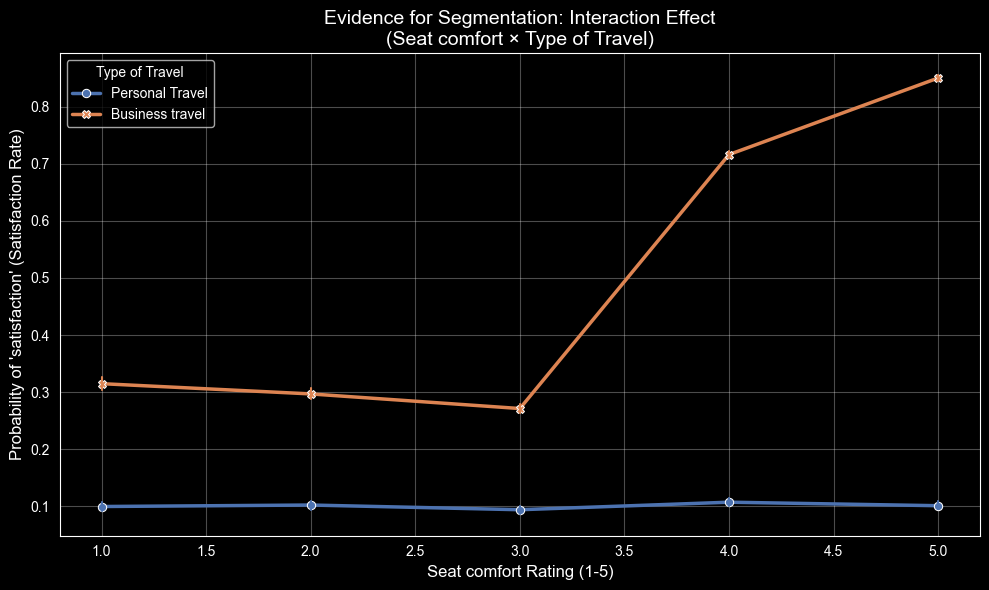

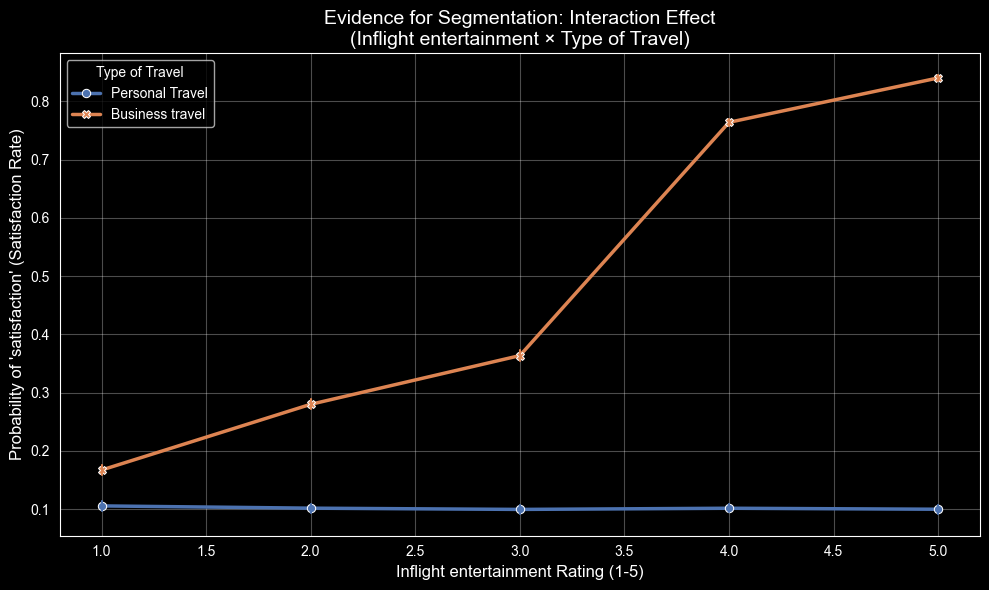

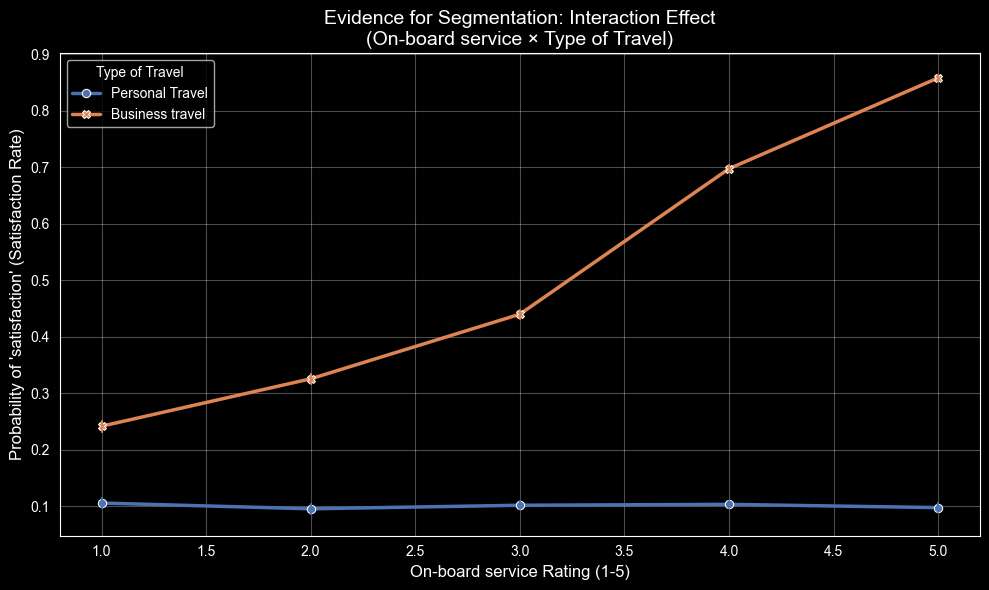

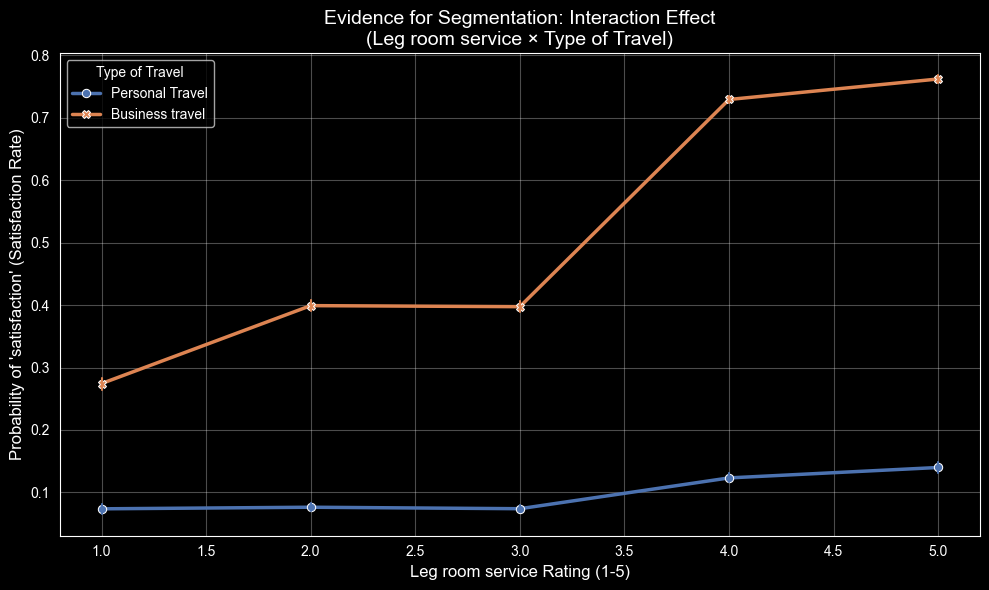

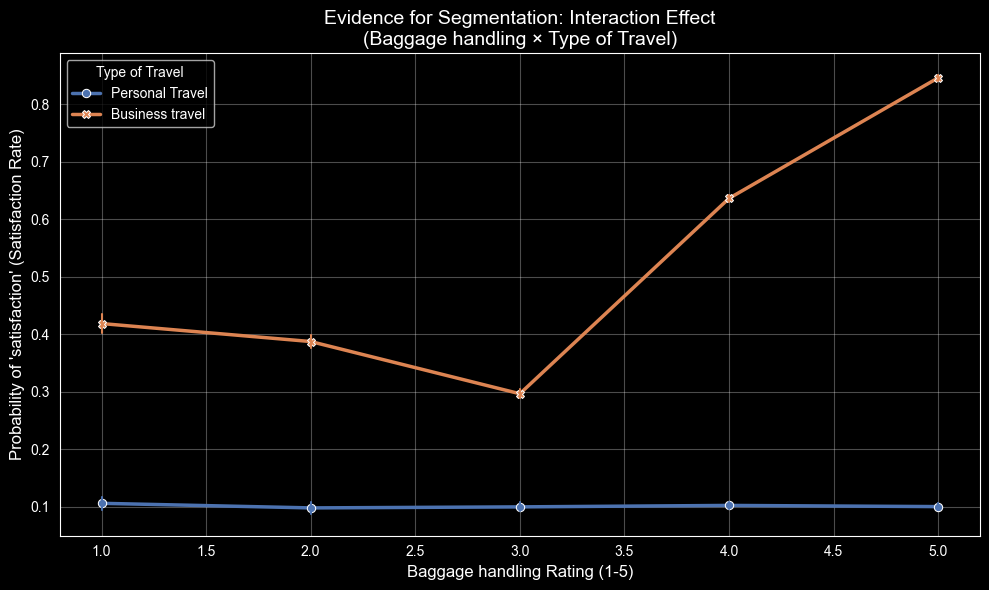

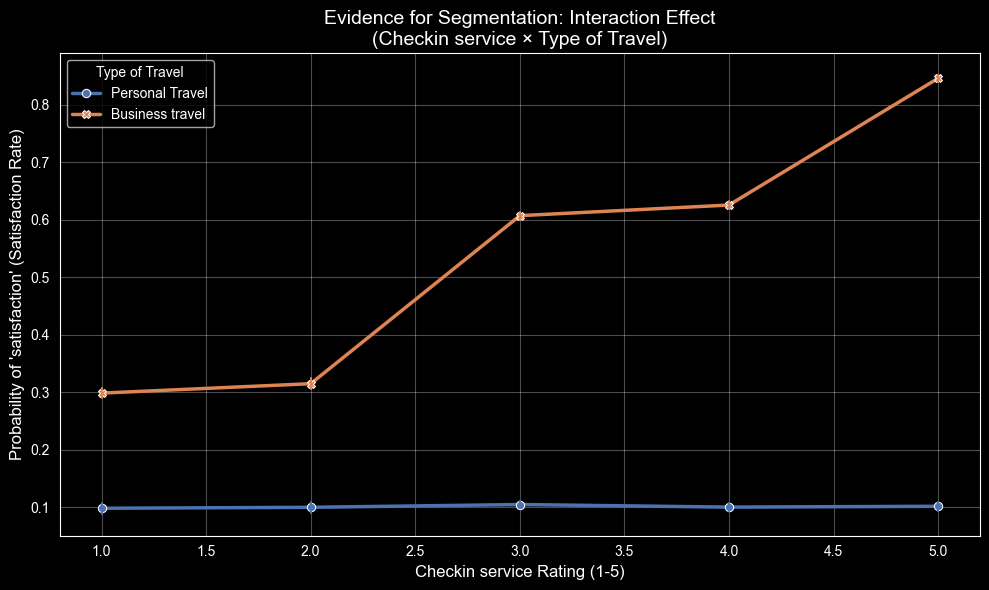

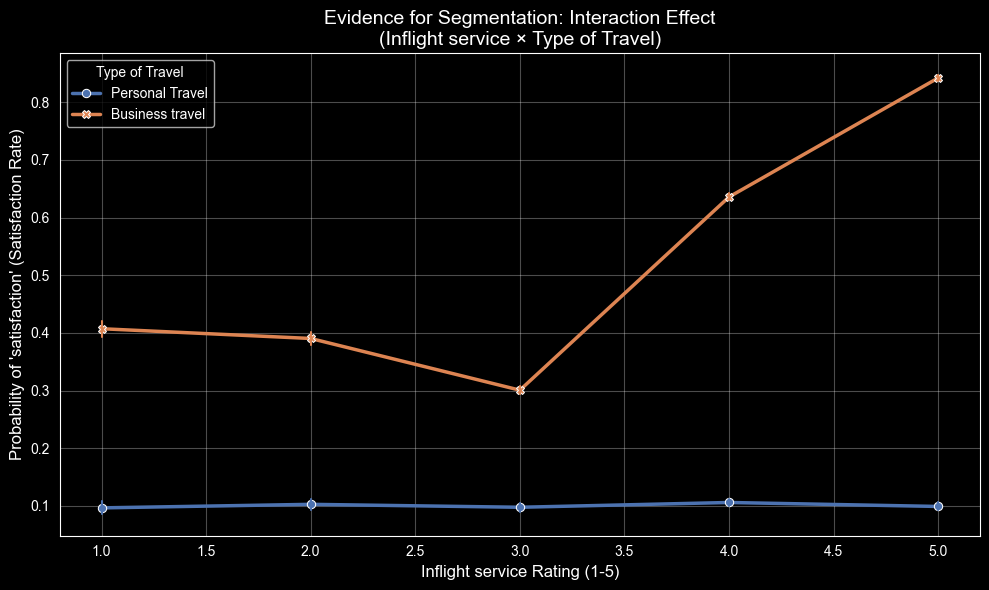

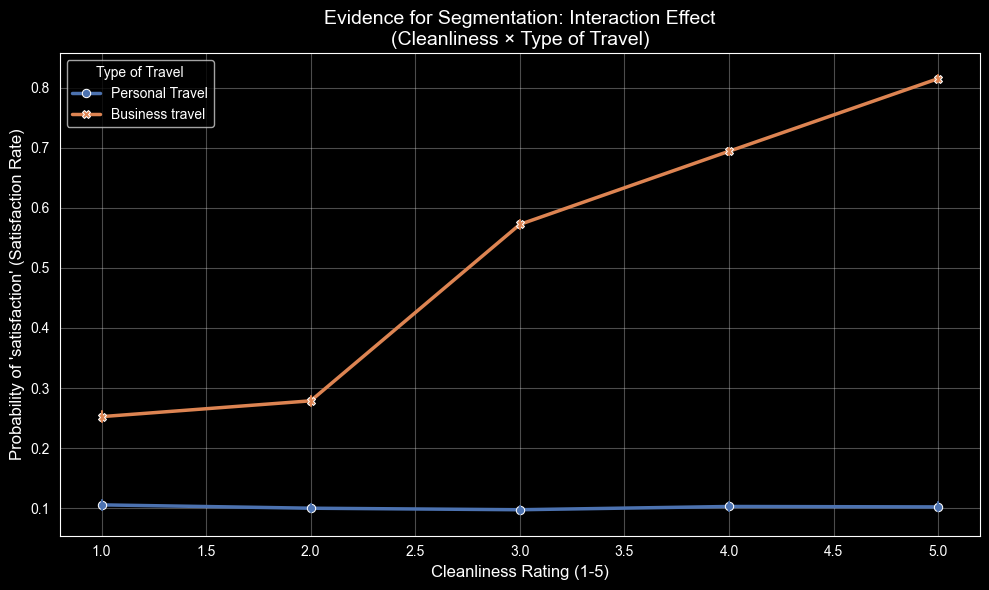

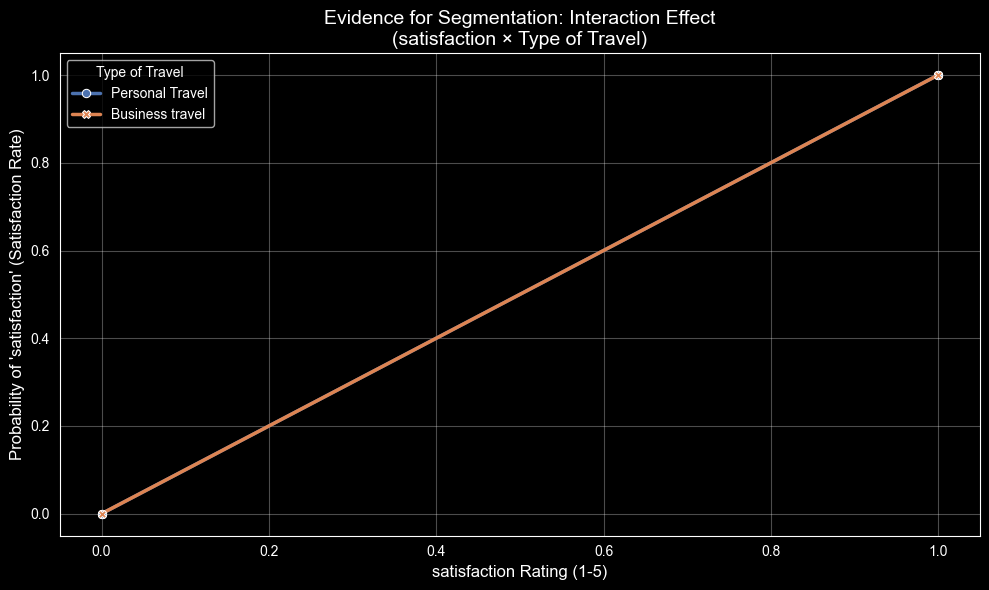

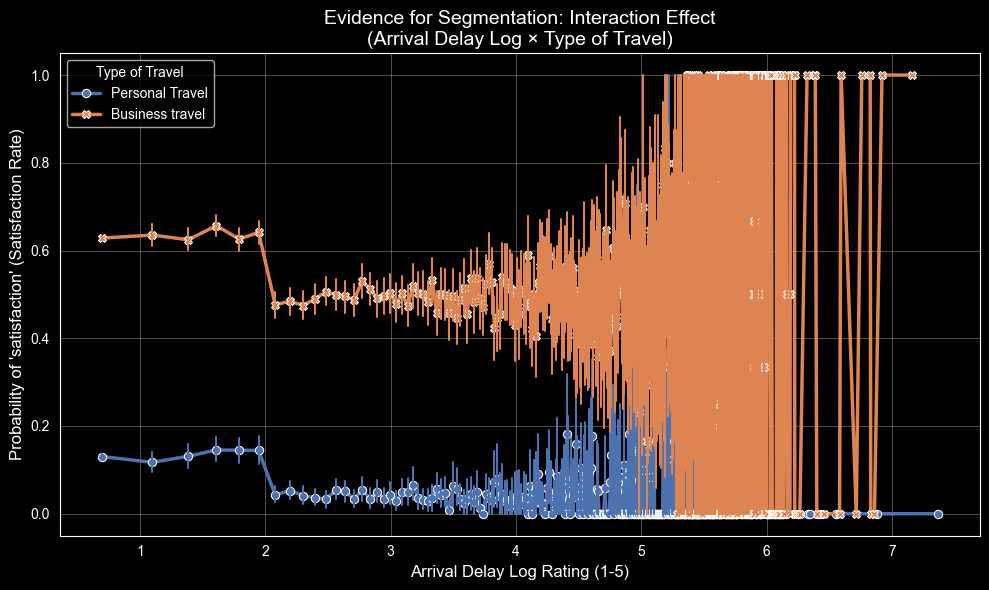

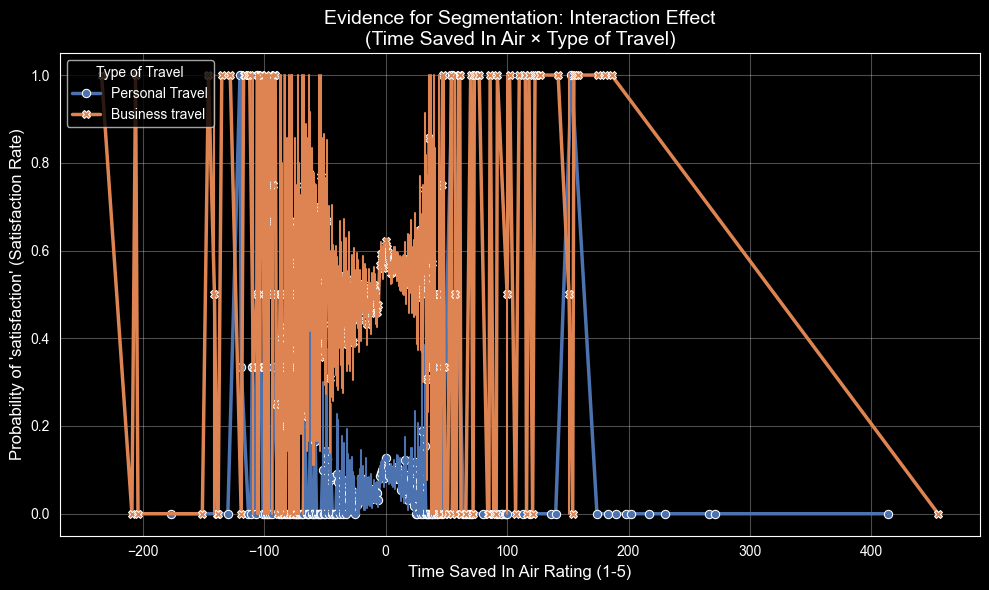

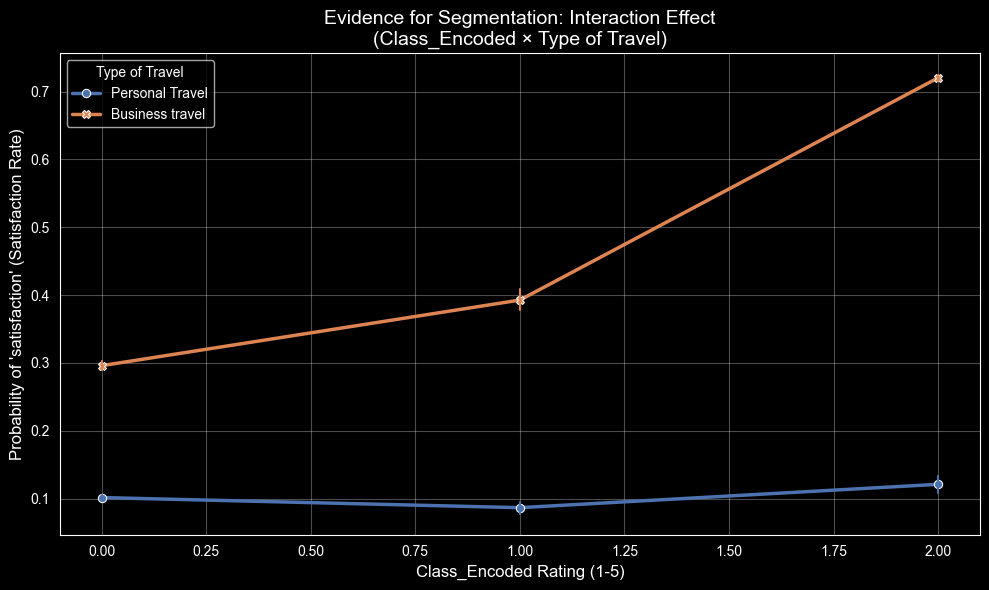

In [51]:
for col in df_train.columns:
    dp.plot_interaction_evidence(
        df_train,
        x_col=col,
        target_col=cfg.TARGET_COL,
        group_col='Type of Travel'
    )

### Class

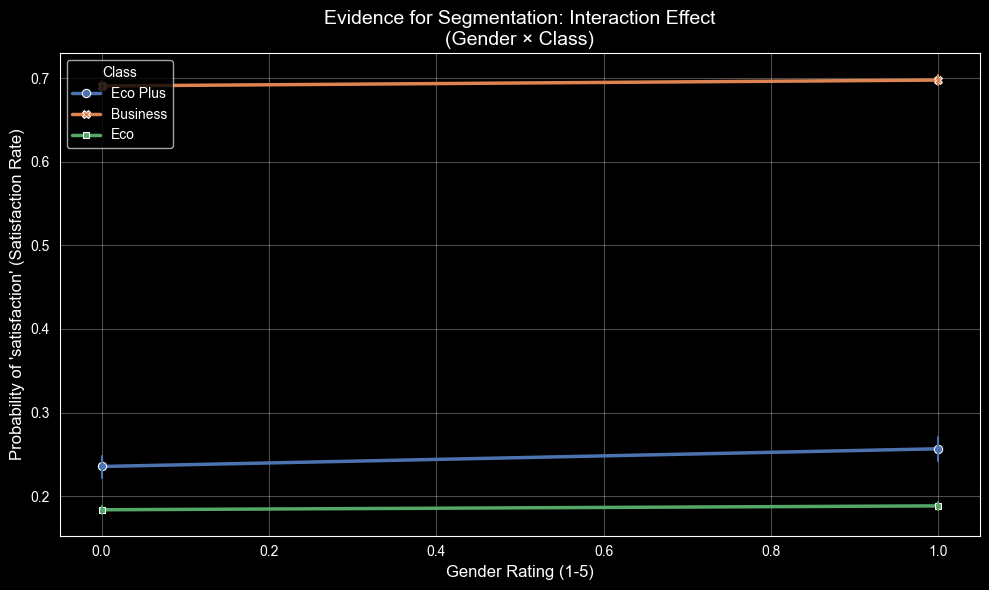

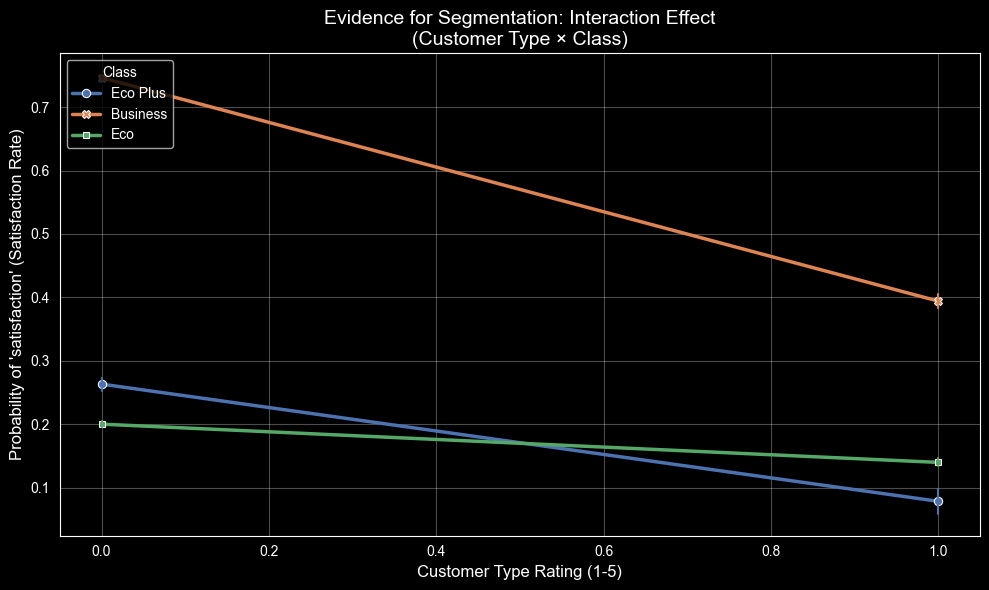

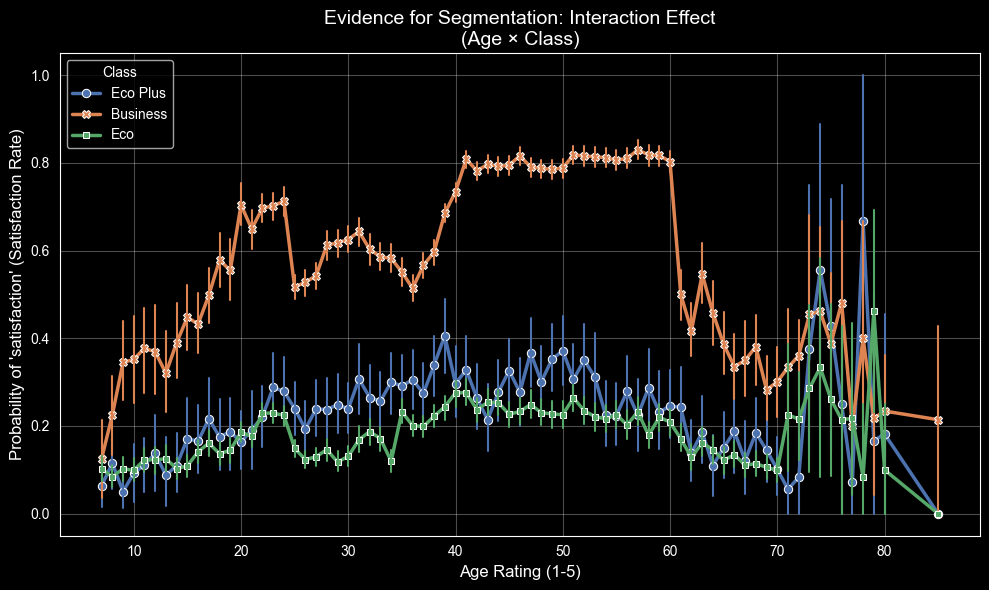

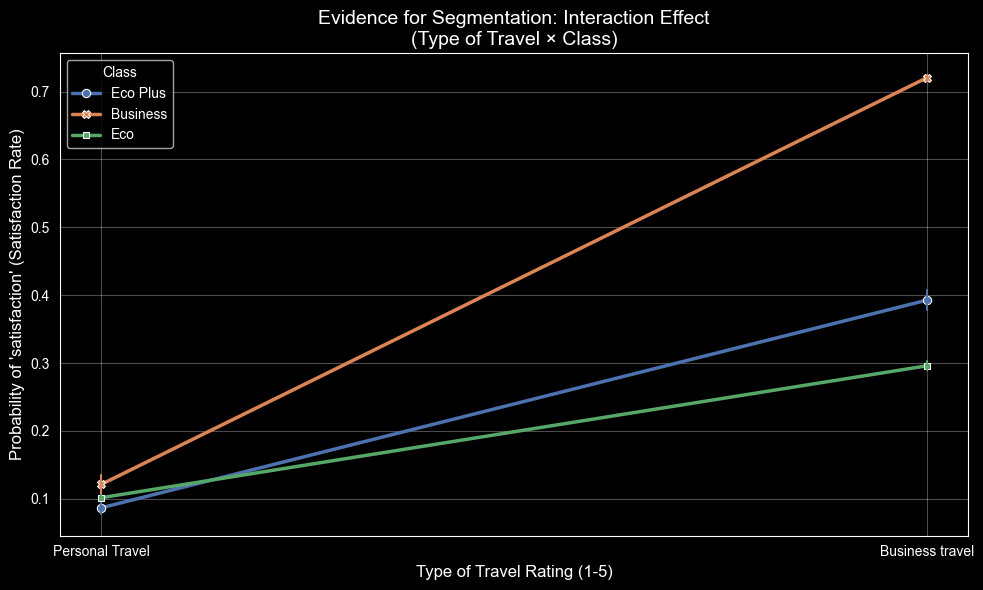

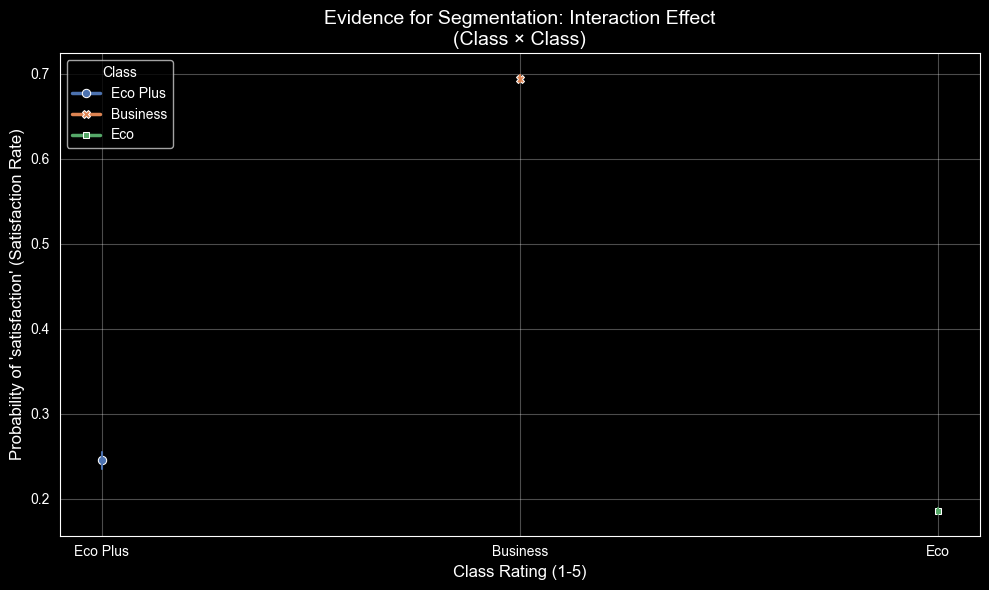

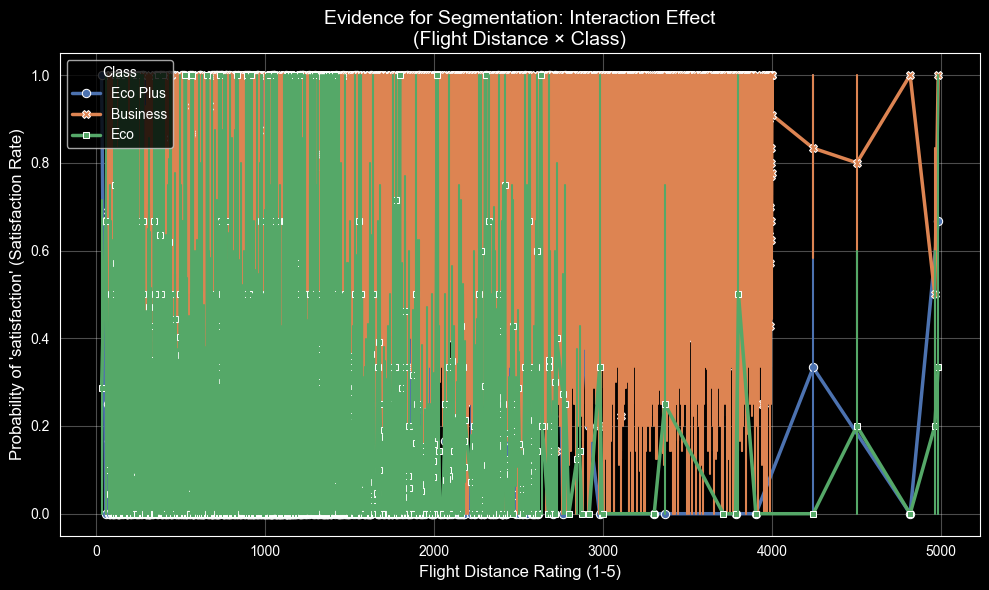

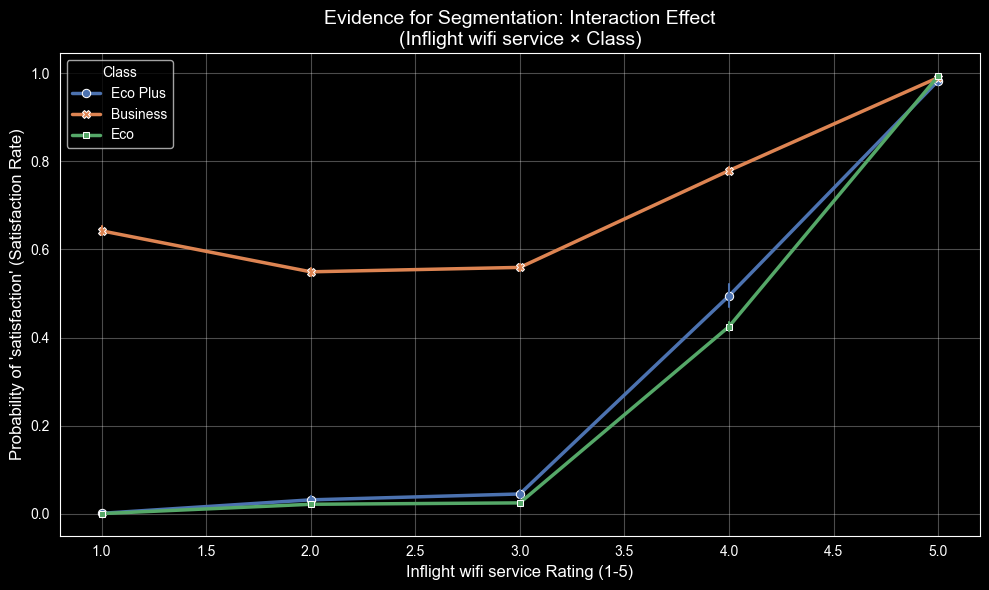

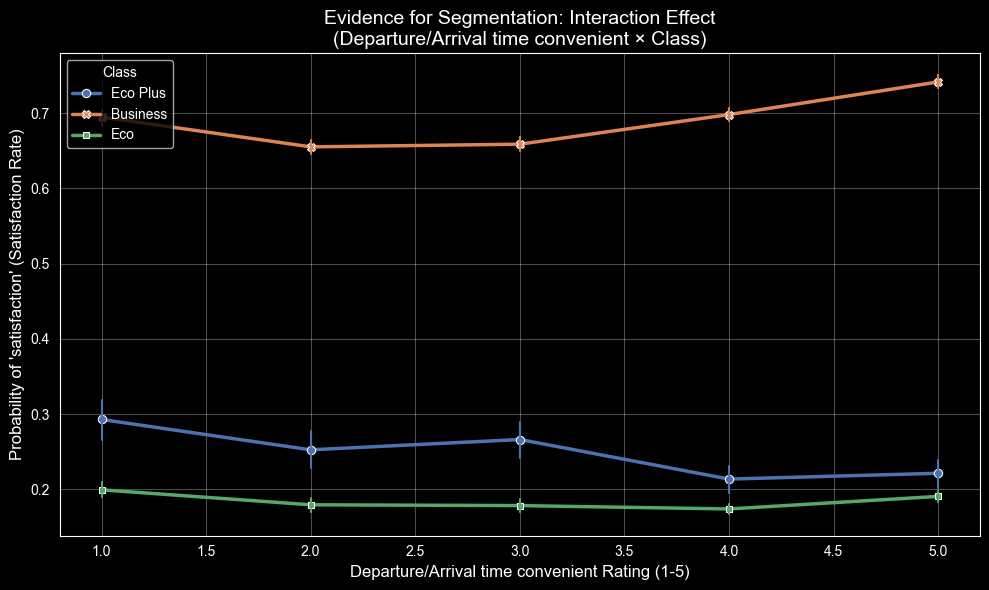

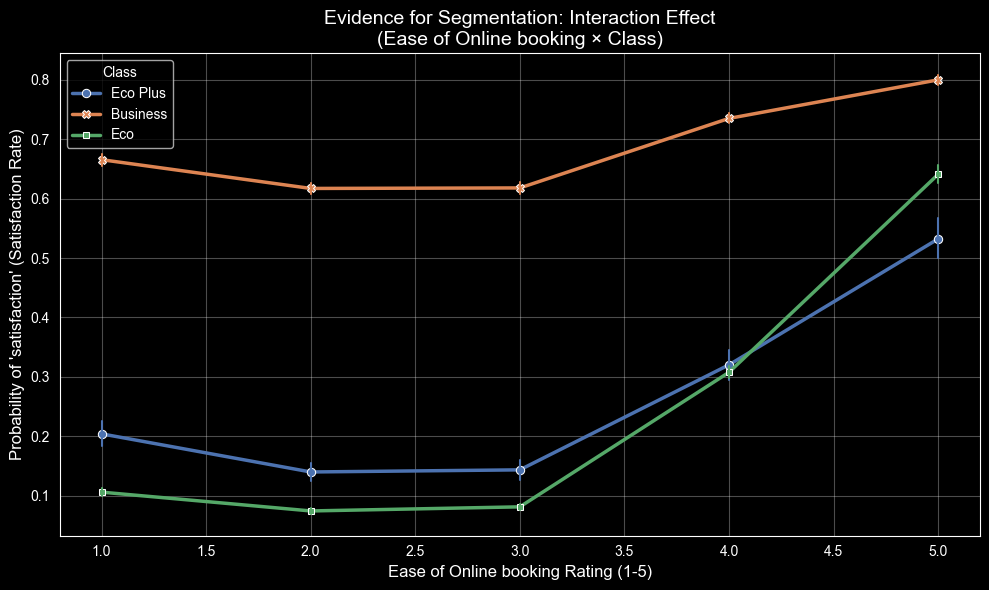

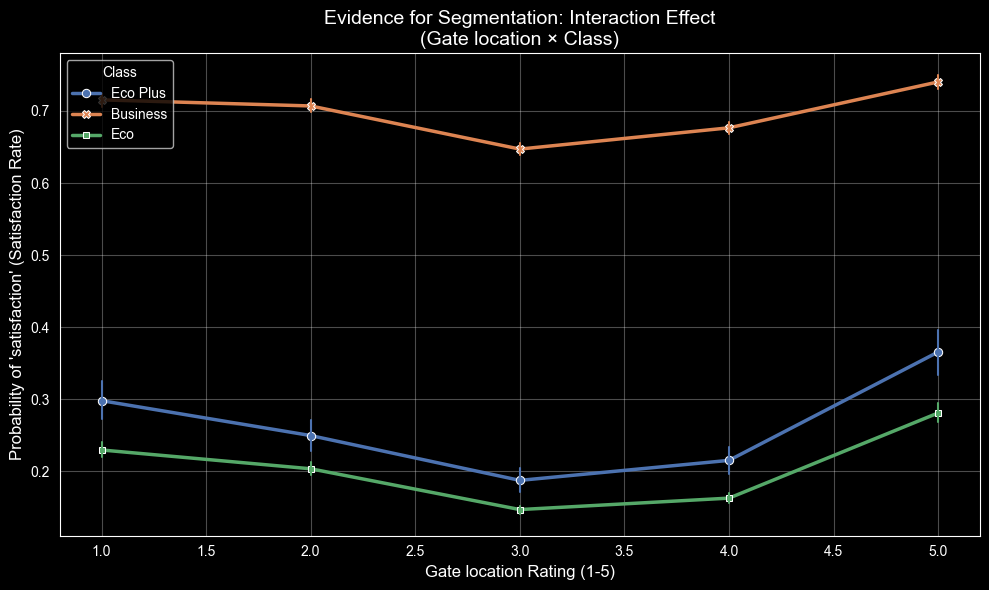

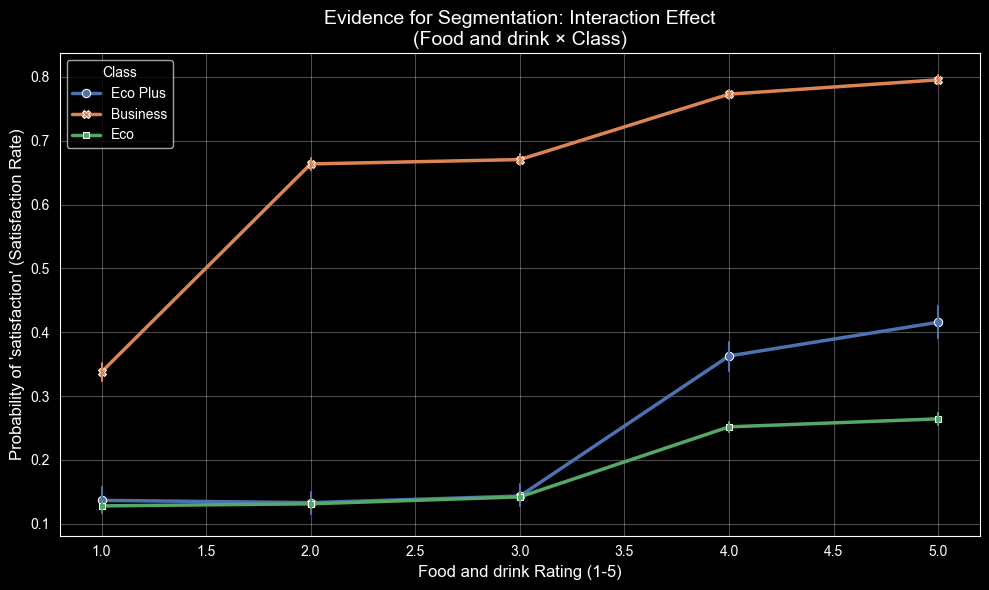

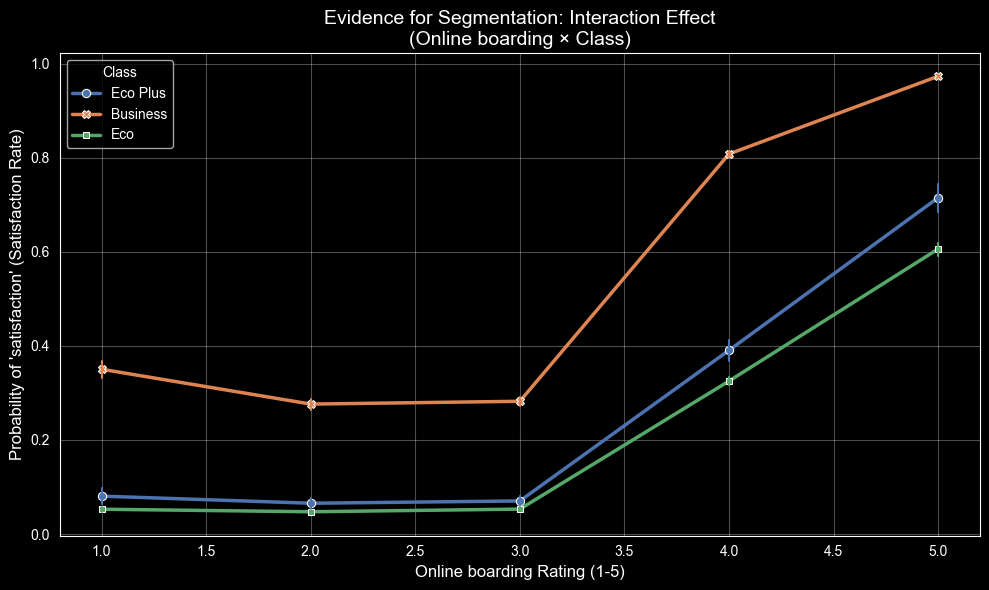

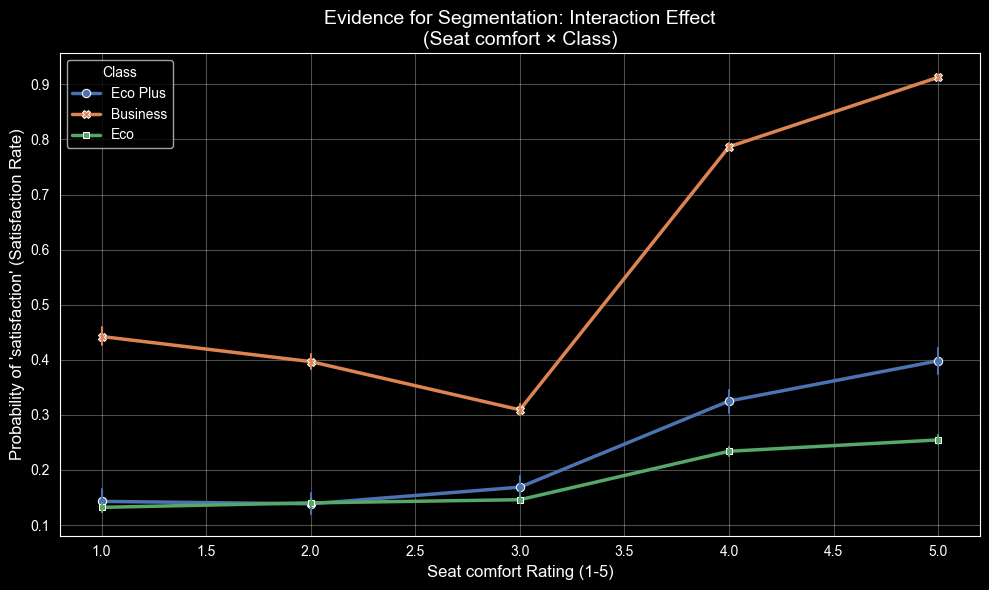

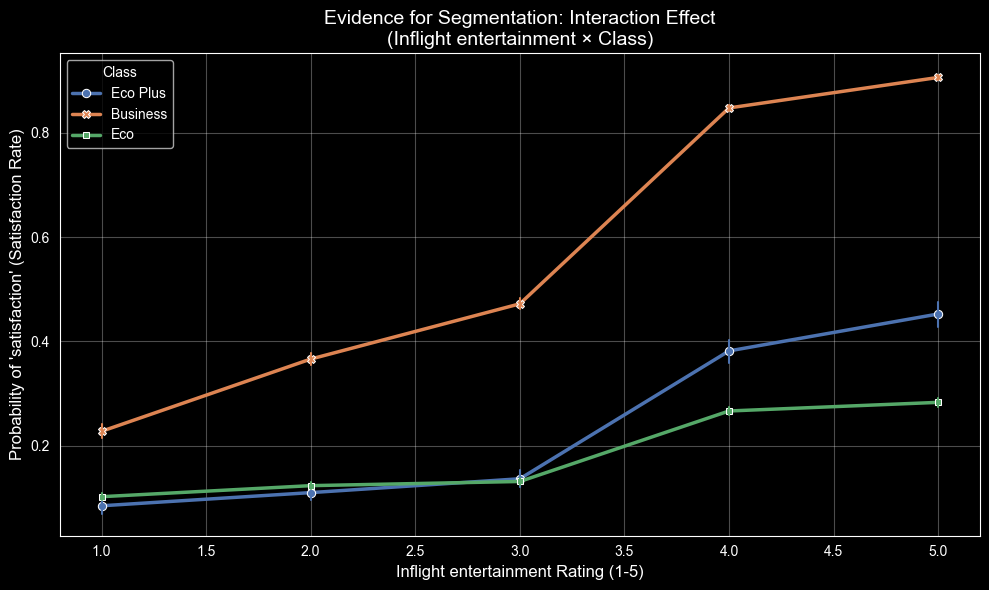

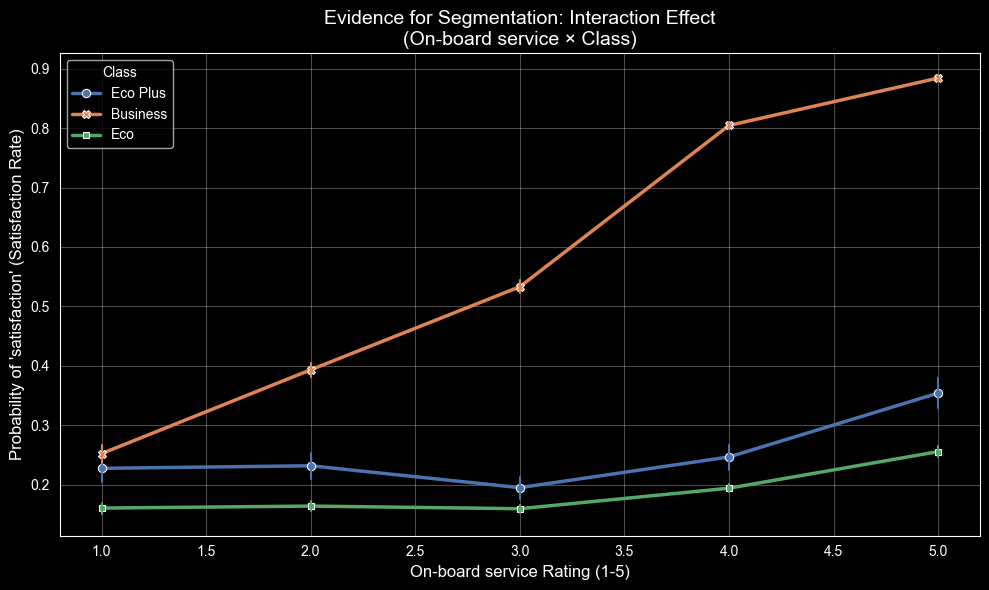

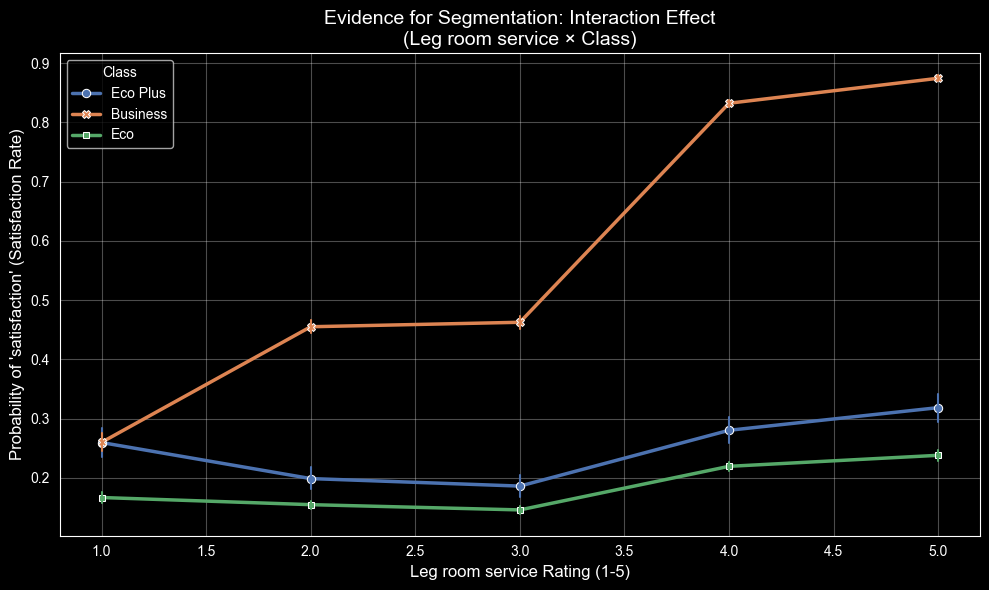

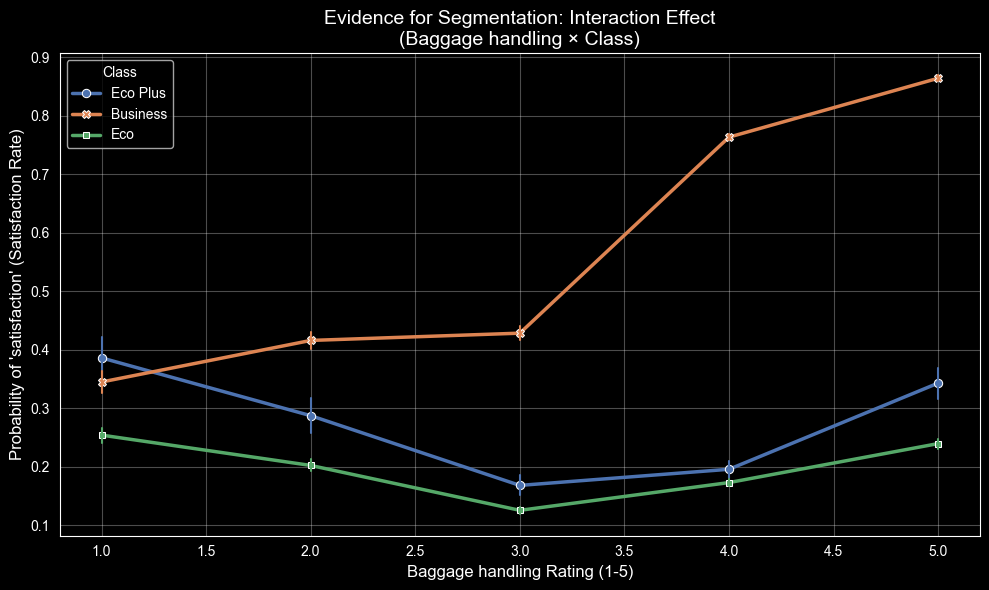

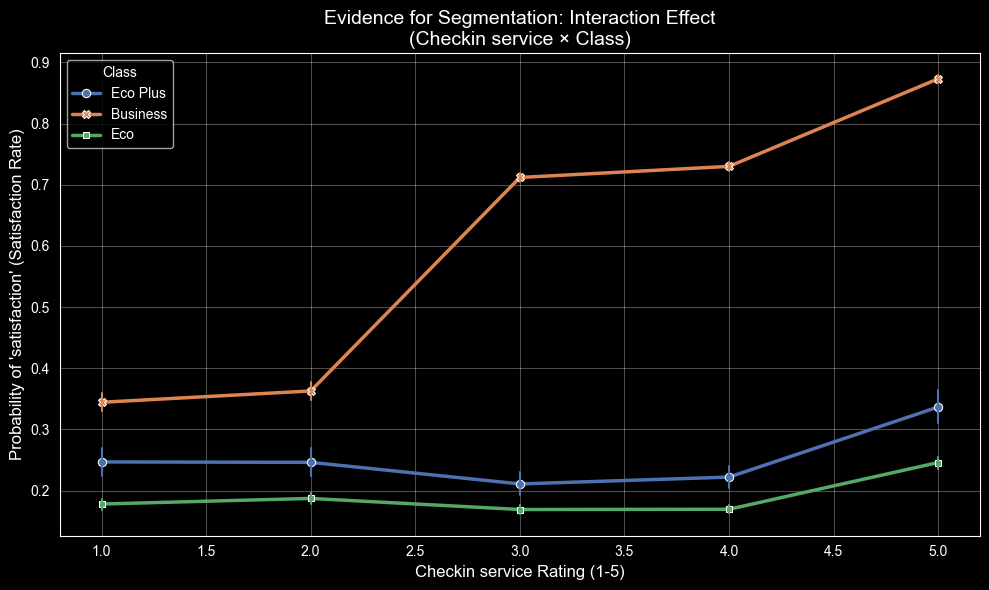

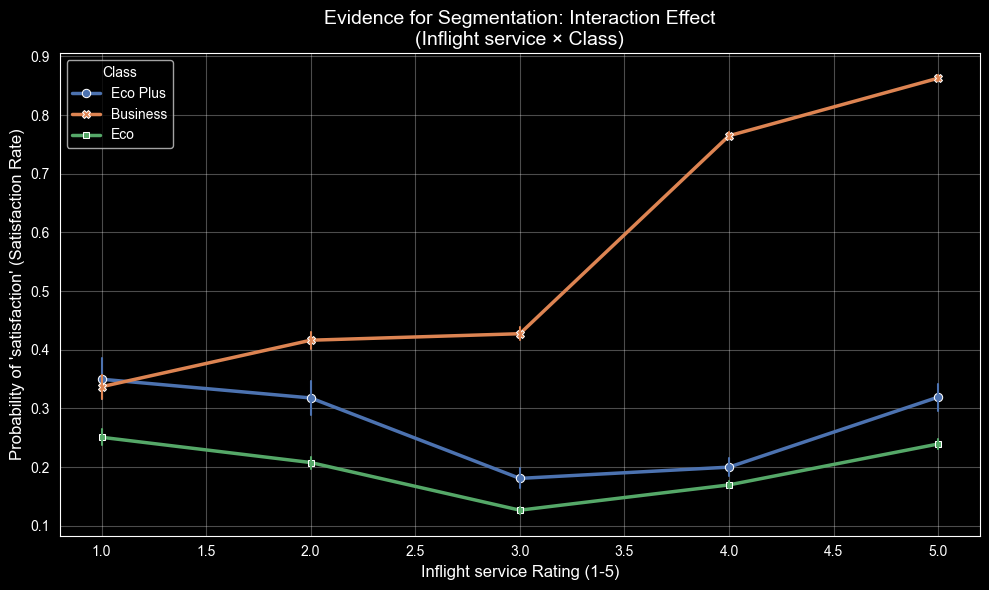

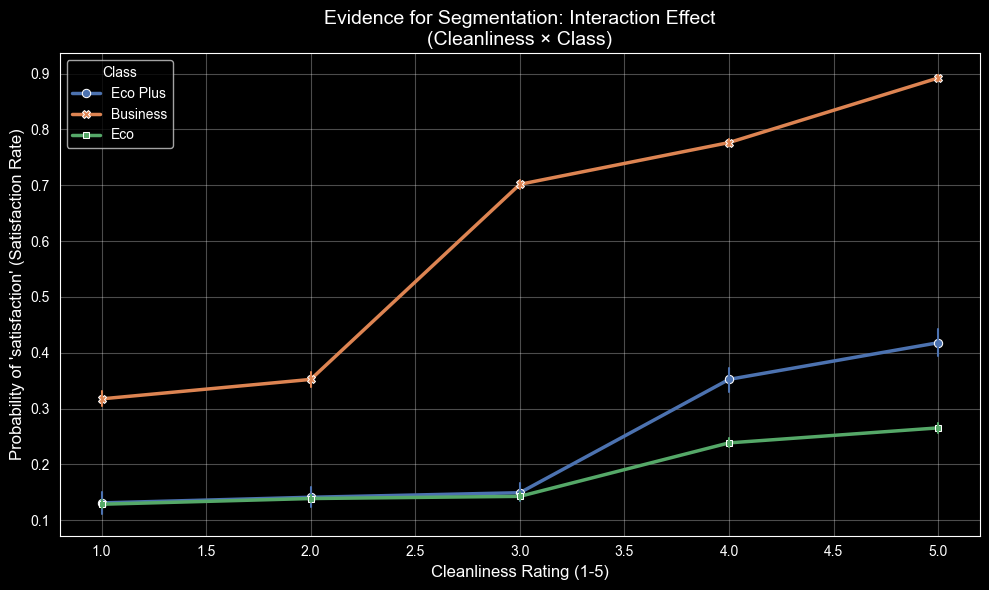

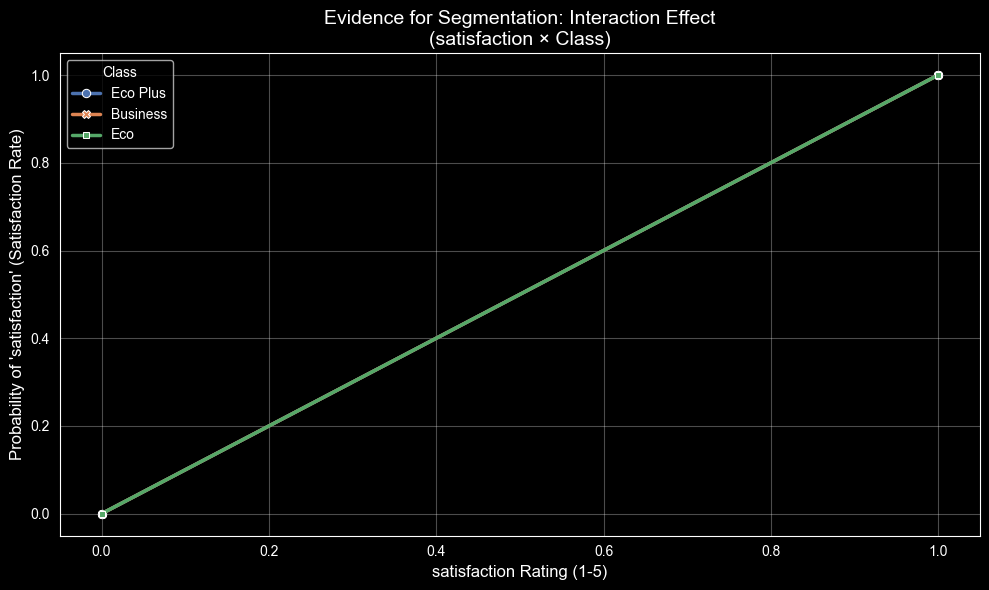

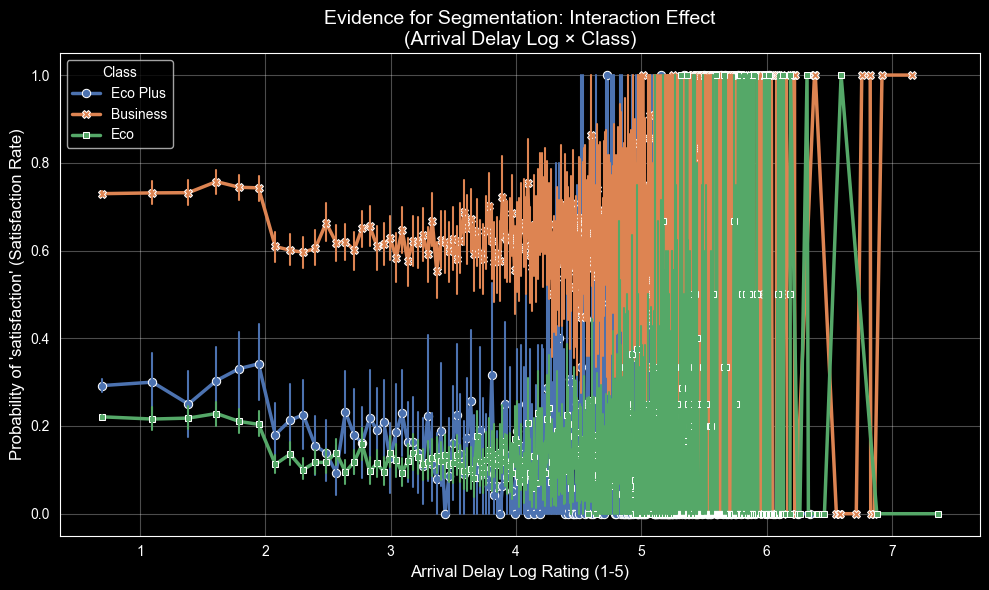

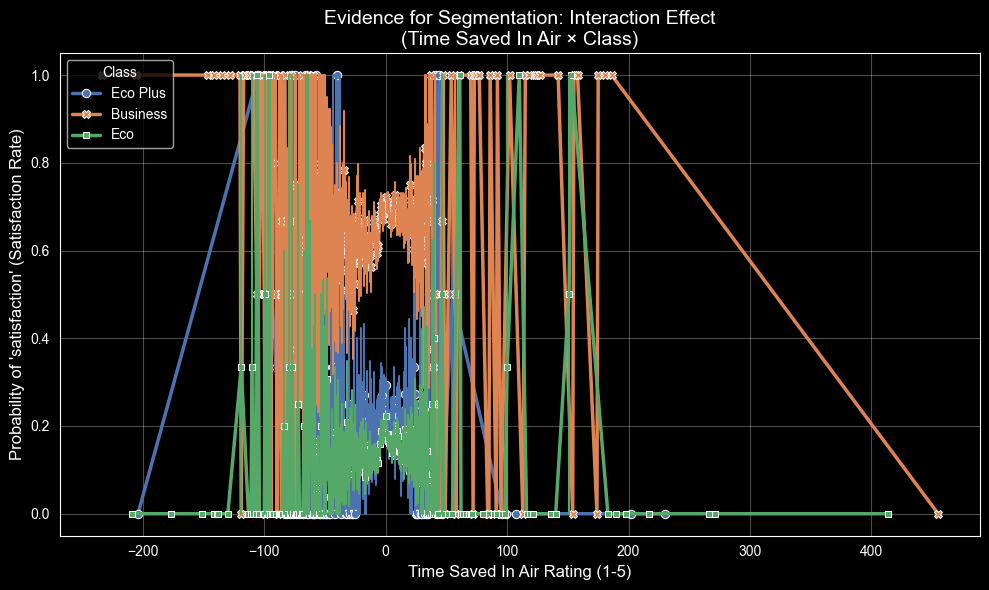

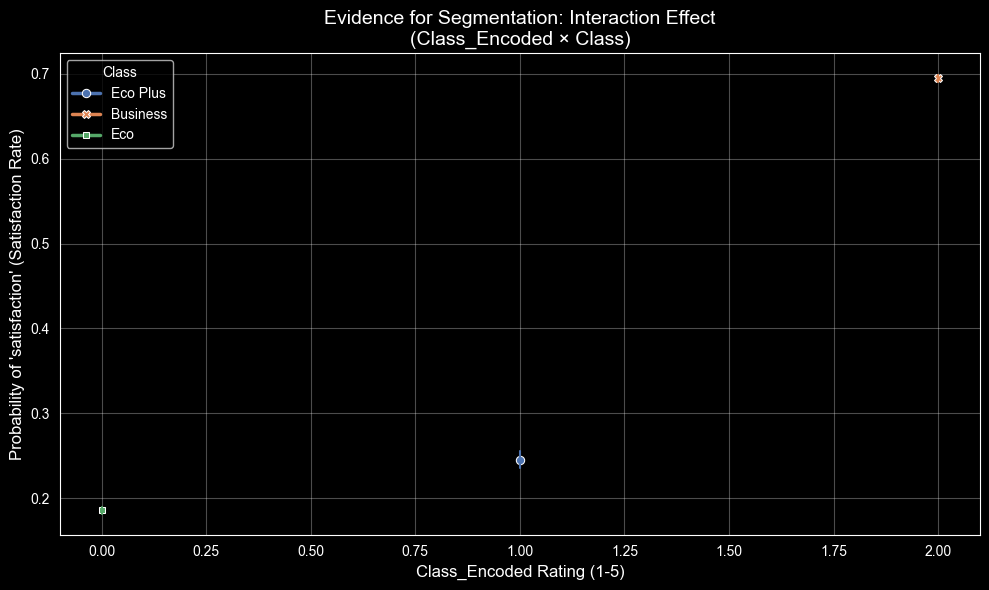

In [52]:
for col in df_train.columns:
    dp.plot_interaction_evidence(
        df_train,
        x_col=col,
        target_col=cfg.TARGET_COL,
        group_col='Class'
    )

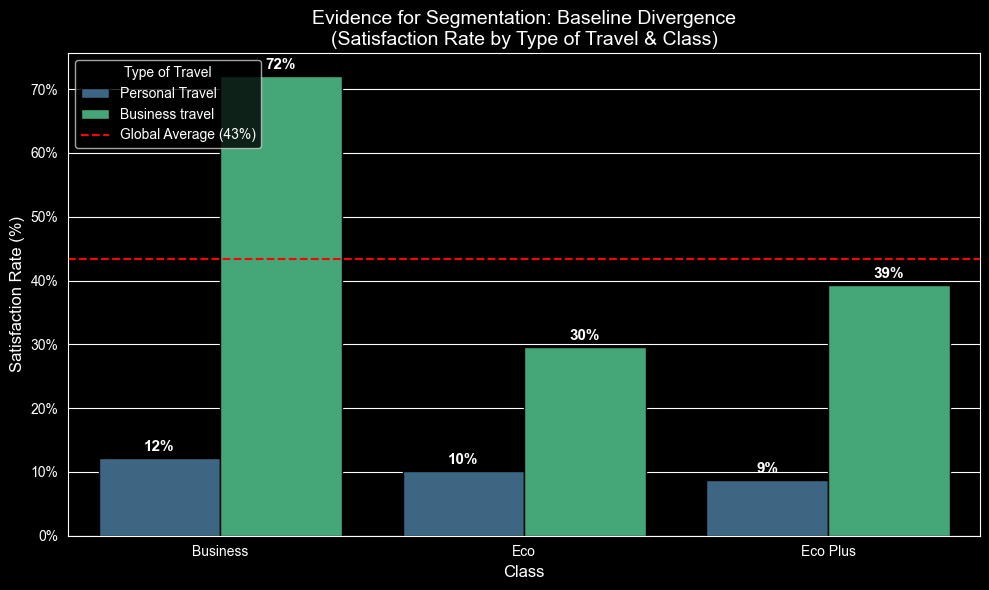

In [28]:
dp.plot_baseline_divergence(
    df_train,
    class_col='Class',
    type_col='Type of Travel',
    target_col=cfg.TARGET_COL
)

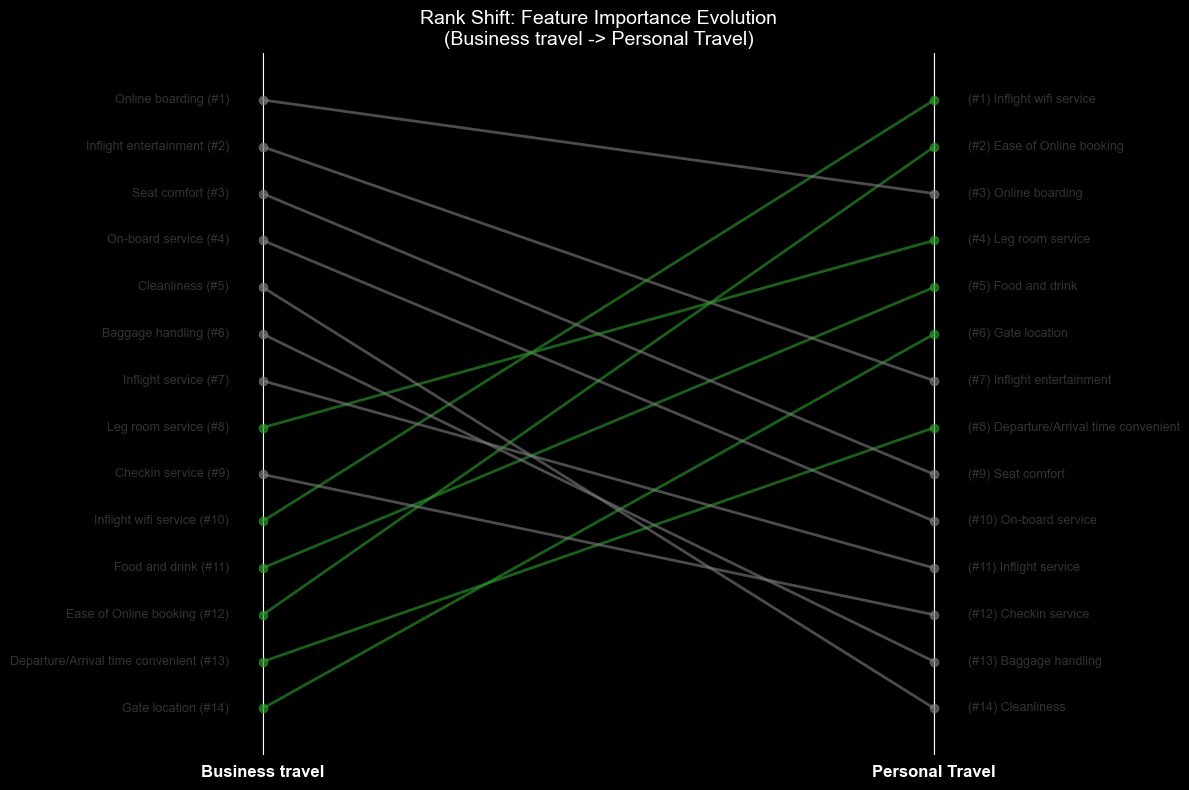

In [29]:
dp.plot_rank_shift(
    df_train,
    service_cols=cfg.SERVICE_COLS,
    target_col=cfg.TARGET_COL,
    group_col='Type of Travel',
    top_n=10
)

In [30]:
_, num_col, _ = dp.get_metadata(df_train)

In [31]:
num_col

['Age',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'Cleanliness',
 'Arrival Delay Log',
 'Time Saved In Air']

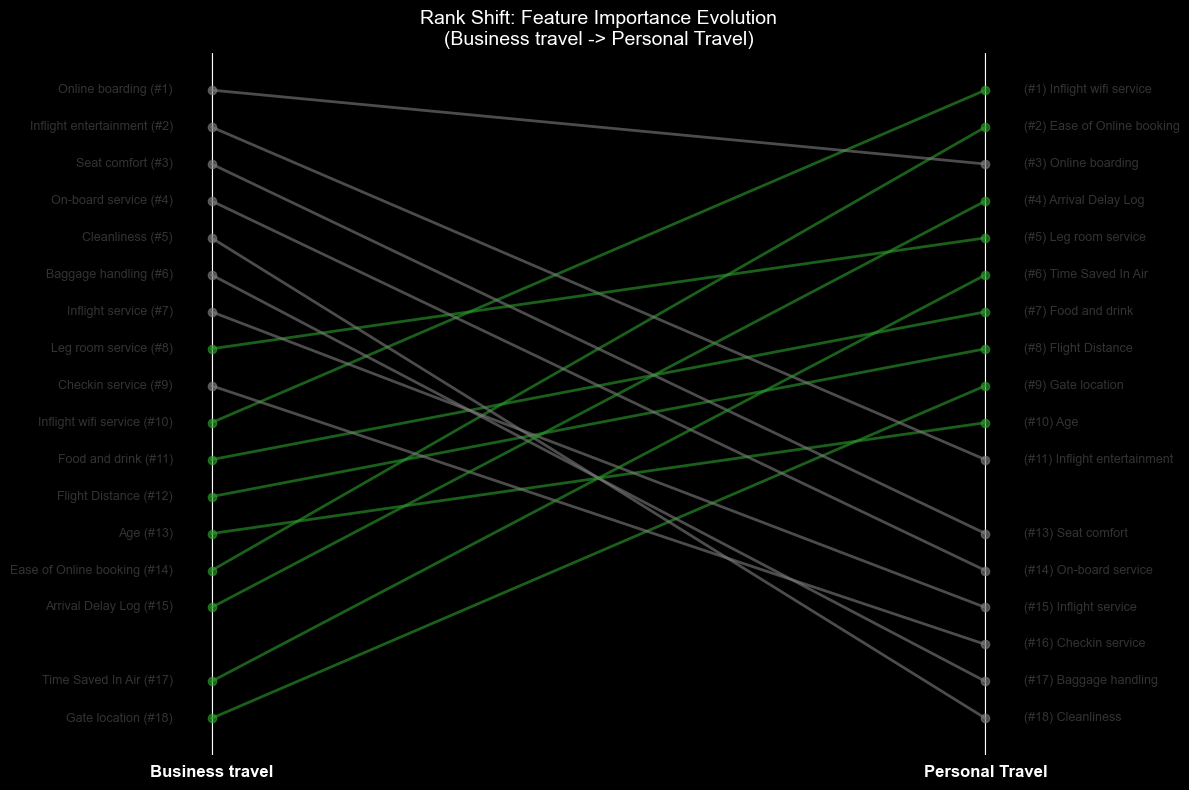

In [32]:
dp.plot_rank_shift(
    df_train,
    service_cols=num_col,
    target_col=cfg.TARGET_COL,
    group_col='Type of Travel',
    top_n=10
)

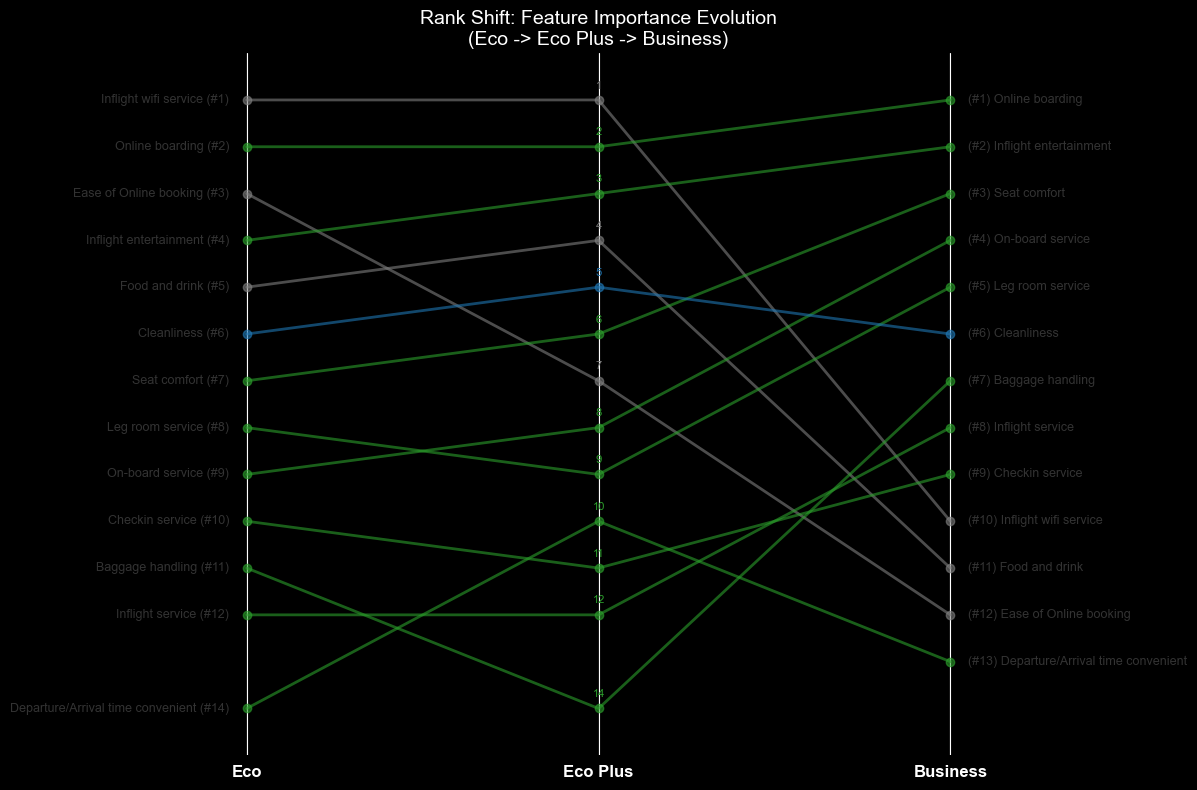

In [33]:
dp.plot_rank_shift(
    df_train,
    service_cols=cfg.SERVICE_COLS,
    target_col=cfg.TARGET_COL,
    group_col='Class',
    group_order=['Eco', 'Eco Plus', 'Business'],
    top_n=10
)

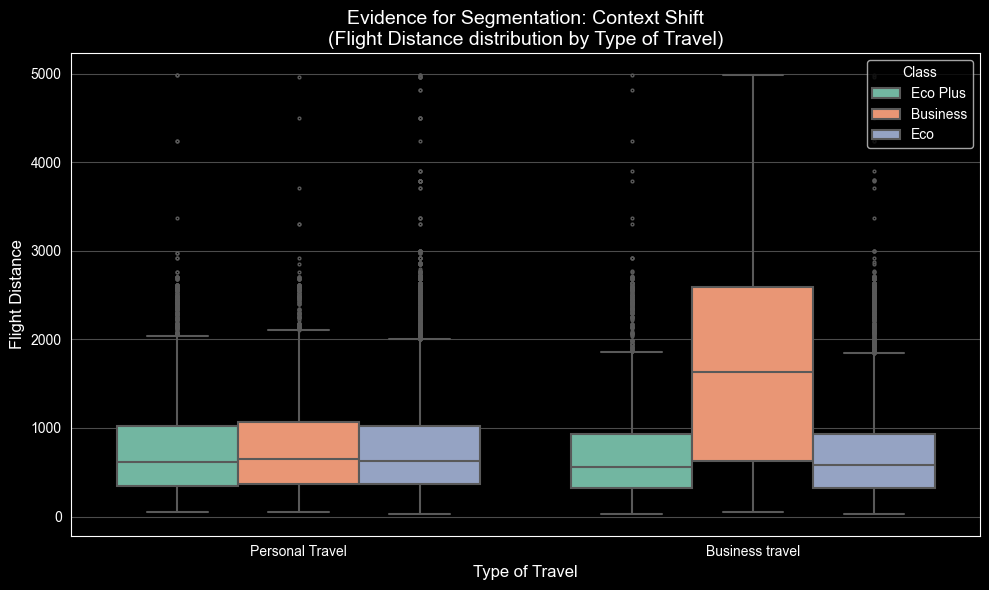

In [34]:
dp.plot_distribution_shift(
    df_train,
    feature_col='Flight Distance',
    group_col='Type of Travel',
    hue_col='Class'
)

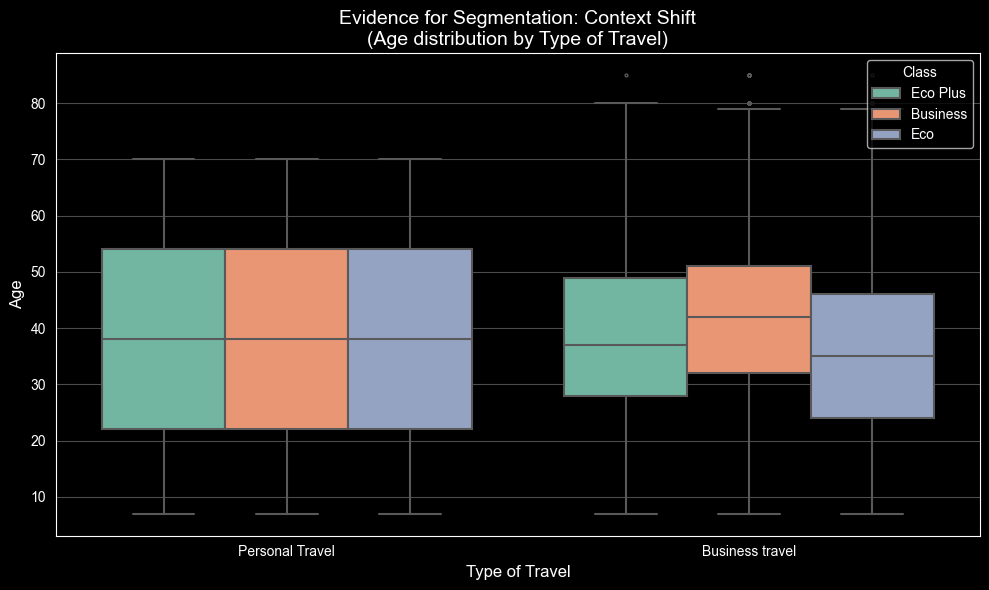

In [35]:
dp.plot_distribution_shift(
    df_train,
    feature_col='Age',
    group_col='Type of Travel',
    hue_col='Class'
)

## Global Encoding

In [36]:
cfg.ENCODER_MANUAL_CONFIG

{'Class': {'Map': {'Eco': 0, 'Eco Plus': 1, 'Business': 2},
  'Suffix': '_Encoded'}}

In [37]:
cfg.AUTO_ENCODING_COLS

['Gender', 'Customer Type']

In [38]:
encoder = GlobalEncoder(
    manual_mappings=cfg.ENCODER_MANUAL_CONFIG,
    auto_cols=cfg.AUTO_ENCODING_COLS
)

In [39]:
df_train.head(5)

Gender      Customer Type  Age   Type of Travel     Class  Flight Distance  \
0    Male     Loyal Customer   13  Personal Travel  Eco Plus              460   
1    Male  disloyal Customer   25  Business travel  Business              235   
2  Female     Loyal Customer   26  Business travel  Business             1142   
3  Female     Loyal Customer   25  Business travel  Business              562   
4    Male     Loyal Customer   61  Business travel  Business              214   

   Inflight wifi service  Departure/Arrival time convenient  \
0                    3.0                                4.0   
1                    3.0                                2.0   
2                    2.0                                2.0   
3                    2.0                                5.0   
4                    3.0                                3.0   

   Ease of Online booking  Gate location  Food and drink  Online boarding  \
0                     3.0              1               5              3.0   
1                     3.0              3               1              3.0   
2                     2.0              2               5              5.0   
3                     5.0              5               2              2.0   
4                     3.0              3               4              5.0   

   Seat comfort  Inflight entertainment  On-board service  Leg room service  \
0             5                       5                 4               3.0   
1             1                       1                 1               5.0   
2             5                       5                 4               3.0   
3             2                       2                 2               5.0   
4             5                       3                 3               4.0   

   Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                 4                4                 5            5   
1                 3                1                 4            1   
2                 4                4                 4            5   
3                 3                1                 4            2   
4                 4                3                 3            3   

              satisfaction  Arrival Delay Log  Time Saved In Air  
0  neutral or dissatisfied           2.995732                7.0  
1  neutral or dissatisfied           2.079442               -5.0  
2                satisfied           0.693147                0.0  
3  neutral or dissatisfied           2.397895                2.0  
4                satisfied           0.693147                0.0

In [40]:
df_train = encoder.fit_transform(df_train)
df_test = encoder.transform(df_test)

GlobalEncoder fitted on 2 auto-columns.
Created column 'Class_Encoded' using manual mapping.
Created column 'Class_Encoded' using manual mapping.


In [41]:
df_train.head(5)

Gender  Customer Type  Age   Type of Travel     Class  Flight Distance  \
0       1              0   13  Personal Travel  Eco Plus              460   
1       1              1   25  Business travel  Business              235   
2       0              0   26  Business travel  Business             1142   
3       0              0   25  Business travel  Business              562   
4       1              0   61  Business travel  Business              214   

   Inflight wifi service  Departure/Arrival time convenient  \
0                    3.0                                4.0   
1                    3.0                                2.0   
2                    2.0                                2.0   
3                    2.0                                5.0   
4                    3.0                                3.0   

   Ease of Online booking  Gate location  Food and drink  Online boarding  \
0                     3.0              1               5              3.0   
1                     3.0              3               1              3.0   
2                     2.0              2               5              5.0   
3                     5.0              5               2              2.0   
4                     3.0              3               4              5.0   

   Seat comfort  Inflight entertainment  On-board service  Leg room service  \
0             5                       5                 4               3.0   
1             1                       1                 1               5.0   
2             5                       5                 4               3.0   
3             2                       2                 2               5.0   
4             5                       3                 3               4.0   

   Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                 4                4                 5            5   
1                 3                1                 4            1   
2                 4                4                 4            5   
3                 3                1                 4            2   
4                 4                3                 3            3   

              satisfaction  Arrival Delay Log  Time Saved In Air  \
0  neutral or dissatisfied           2.995732                7.0   
1  neutral or dissatisfied           2.079442               -5.0   
2                satisfied           0.693147                0.0   
3  neutral or dissatisfied           2.397895                2.0   
4                satisfied           0.693147                0.0   

   Class_Encoded  
0              1  
1              2  
2              2  
3              2  
4              2

In [42]:
cfg.TARGET_MAP

{'neutral or dissatisfied': 0, 'satisfied': 1}

In [43]:
df_train[cfg.TARGET_COL] = df_train[cfg.TARGET_COL].map(cfg.TARGET_MAP)
df_test[cfg.TARGET_COL] = df_test[cfg.TARGET_COL].map(cfg.TARGET_MAP)

In [44]:
print("Encoding complete. Example data:")
df_train[['Class', 'Class_Encoded', 'Type of Travel', 'Gender']].head()

Encoding complete. Example data:


Class  Class_Encoded   Type of Travel  Gender
0  Eco Plus              1  Personal Travel       1
1  Business              2  Business travel       1
2  Business              2  Business travel       0
3  Business              2  Business travel       0
4  Business              2  Business travel       1

## The Core Loop: Segmentation -> Modeling -> Analysis

In [45]:
seg_manager = SegmentManager(cfg.SEGMENT_CONFIGS, cfg.TARGET_COL, min_samples=cfg.MIN_SEGMENT_SIZE)
trainer = ModelTrainer(fixed_params=cfg.XGB_FIXED_PARAMS, random_state=cfg.RANDOM_STATE)
evaluator = ModelEvaluator()
deployer = ModelDeployer(base_path="artifacts")

In [46]:
from src.pipeline import TrainingPipeline

pipeline = TrainingPipeline(trainer, evaluator, deployer)

In [47]:
all_metrics = {}

In [48]:
if 'Type of Travel' in df_train.columns:
    print("Unique values in 'Type of Travel':", df_train['Type of Travel'].unique())
else:
    print("'Type of Travel' column NOT FOUND!")

Columns: ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction', 'Arrival Delay Log', 'Time Saved In Air', 'Class_Encoded']
Unique values in 'Type of Travel': ['Personal Travel' 'Business travel']


Starting segmentation process. Total configurations: 9

Processing segment: Global_All_Data
   Train shape: (103792, 24)
   Test shape:  (25949, 24)

========== Processing: Global_All_Data ==========
   >>> Training XGBoost on 103792 samples...
   [WARNING] Found object columns in X: ['Type of Travel']. Dropping them automatically.
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.8}
   >>> Best CV F1: 0.9509
   [Saved] Model saved to: artifacts\models\Global_All_Data.pkl.pkl
   [Saved] Metrics: artifacts\reports\Global_All_Data_metrics.json
   Metrics: {'Accuracy': 0.9596, 'Precision': 0.9658, 'Recall': 0.9413, 'Specificity': np.float64(0.9739), 'F1-Score': 0.9534, 'ROC_AUC': 0.9939}
   Generating plots for Global_All_Data...
   [Saved] Plot: artifacts\plots\SHAP_Summary_Global_All_Data.png


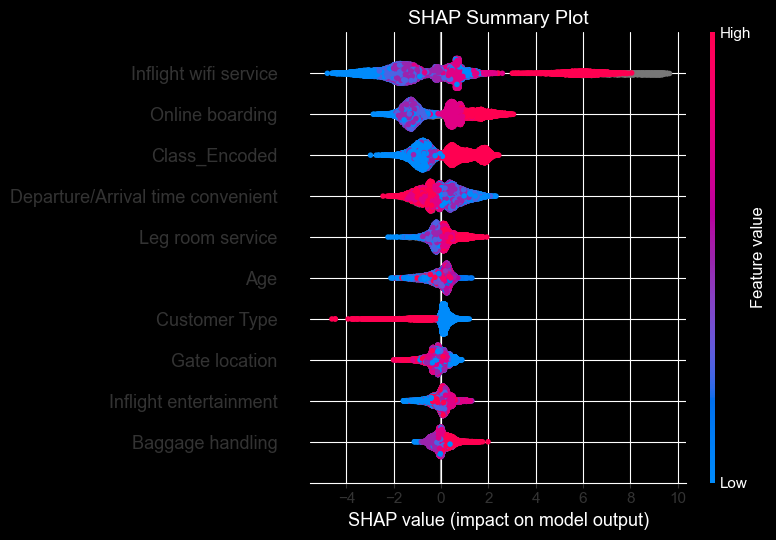

   [Saved] Plot: artifacts\plots\SHAP_Dependence_Global_All_Data_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

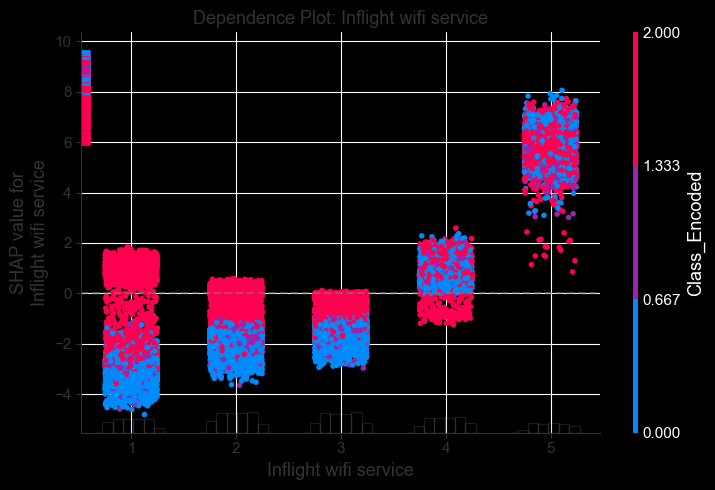

   [Saved] Plot: artifacts\plots\SHAP_Dependence_Global_All_Data_Online boarding.png


<Figure size 800x500 with 0 Axes>

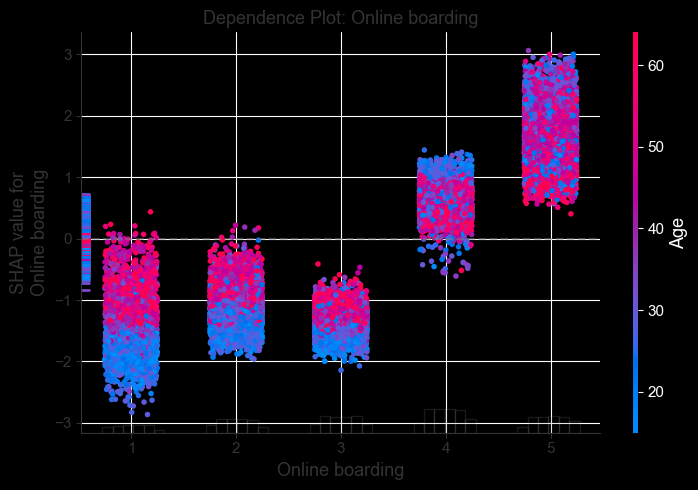

   [Saved] Plot: artifacts\plots\SHAP_Dependence_Global_All_Data_Class_Encoded.png


<Figure size 800x500 with 0 Axes>

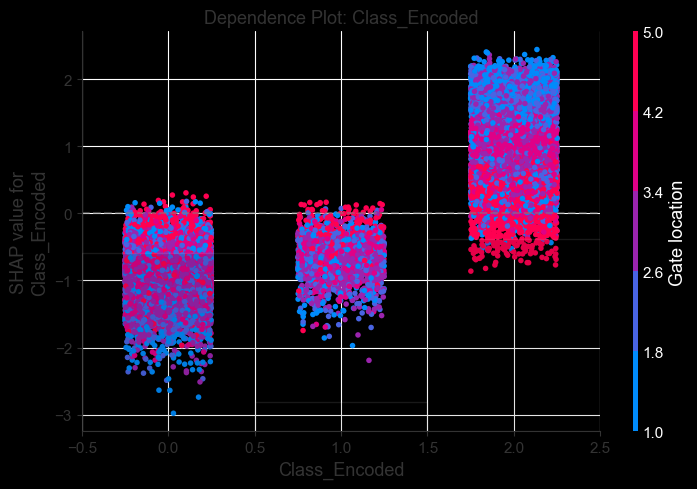


Processing segment: MACRO_Business_travel
   Train shape: (71595, 24)
   Test shape:  (18023, 24)

========== Processing: MACRO_Business_travel ==========
   >>> Training XGBoost on 71595 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.8}
   >>> Best CV F1: 0.9727
   [Saved] Model saved to: artifacts\models\MACRO_Business_travel.pkl.pkl
   [Saved] Metrics: artifacts\reports\MACRO_Business_travel_metrics.json
   Metrics: {'Accuracy': 0.9677, 'Precision': 0.9757, 'Recall': 0.9692, 'Specificity': np.float64(0.9655), 'F1-Score': 0.9724, 'ROC_AUC': 0.9961}
   Generating plots for MACRO_Business_travel...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MACRO_Business_travel.png


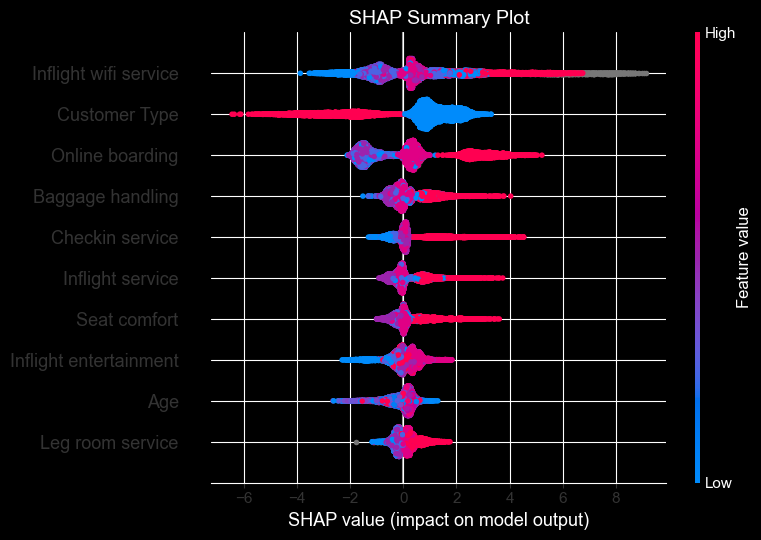

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MACRO_Business_travel_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

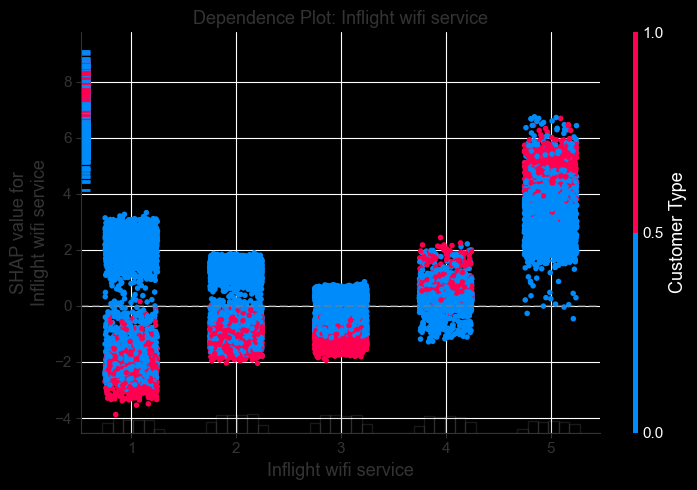

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MACRO_Business_travel_Online boarding.png


<Figure size 800x500 with 0 Axes>

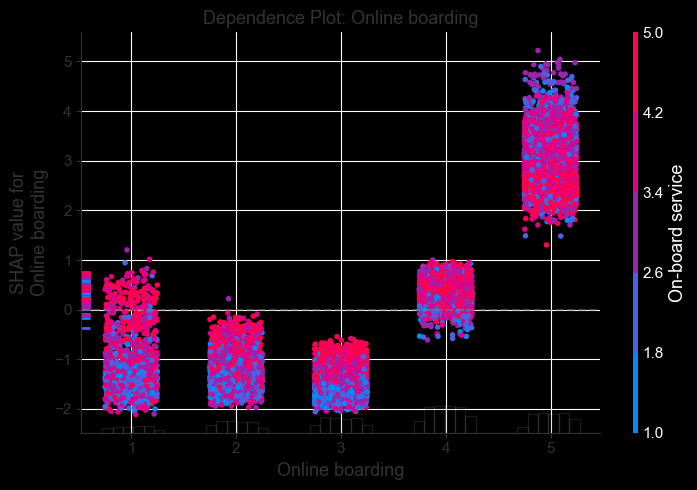


Processing segment: MACRO_Personal_Travel
   Train shape: (32197, 24)
   Test shape:  (7926, 24)

========== Processing: MACRO_Personal_Travel ==========
   >>> Training XGBoost on 32197 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'scale_pos_weight': 1.0, 'subsample': 0.8}
   >>> Best CV F1: 0.7462
   [Saved] Model saved to: artifacts\models\MACRO_Personal_Travel.pkl.pkl
   [Saved] Metrics: artifacts\reports\MACRO_Personal_Travel_metrics.json
   Metrics: {'Accuracy': 0.9595, 'Precision': 0.9876, 'Recall': 0.6028, 'Specificity': np.float64(0.9992), 'F1-Score': 0.7486, 'ROC_AUC': 0.9788}
   Generating plots for MACRO_Personal_Travel...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MACRO_Personal_Travel.png


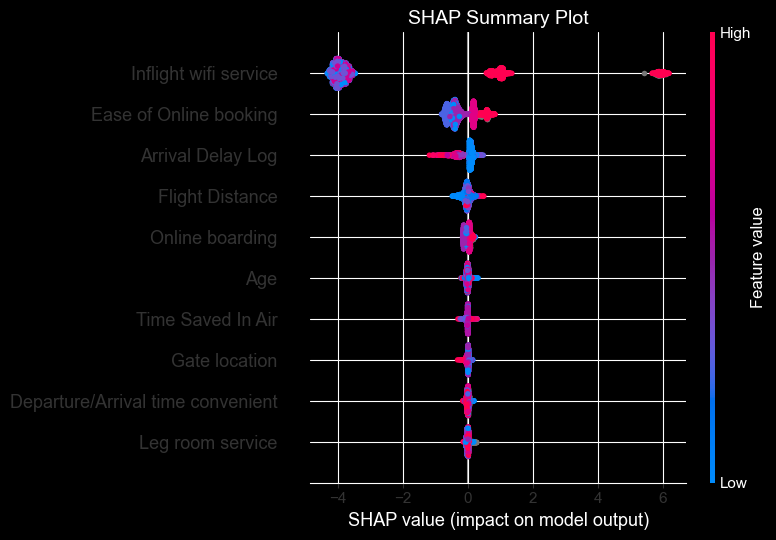

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MACRO_Personal_Travel_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

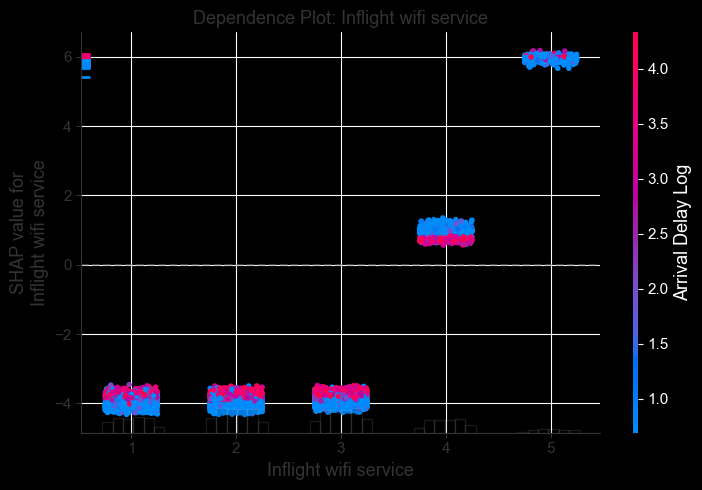

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MACRO_Personal_Travel_Ease of Online booking.png


<Figure size 800x500 with 0 Axes>

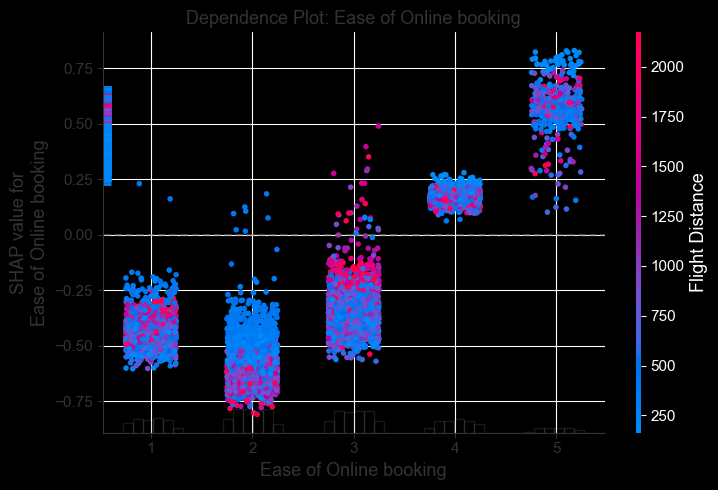

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MACRO_Personal_Travel_Arrival Delay Log.png


<Figure size 800x500 with 0 Axes>

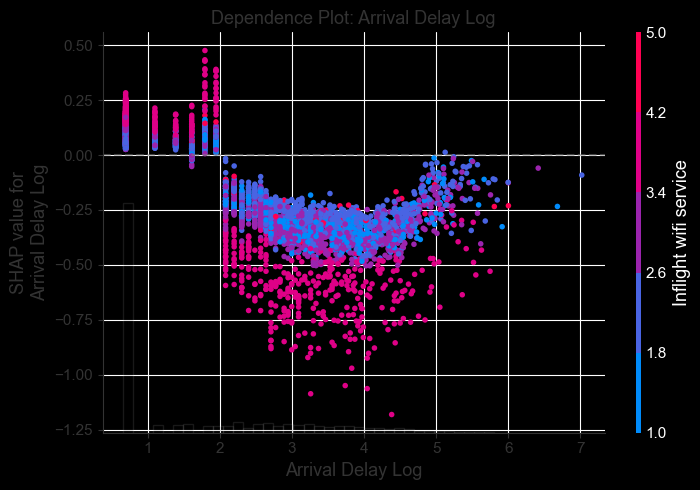


Processing segment: MICRO_Business_travel_Eco
   Train shape: (20242, 24)
   Test shape:  (5041, 24)

========== Processing: MICRO_Business_travel_Eco ==========
   >>> Training XGBoost on 20242 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'scale_pos_weight': 1.0, 'subsample': 0.8}
   >>> Best CV F1: 0.8993
   [Saved] Model saved to: artifacts\models\MICRO_Business_travel_Eco.pkl.pkl
   [Saved] Metrics: artifacts\reports\MICRO_Business_travel_Eco_metrics.json
   Metrics: {'Accuracy': 0.9411, 'Precision': 0.9319, 'Recall': 0.8758, 'Specificity': np.float64(0.9708), 'F1-Score': 0.903, 'ROC_AUC': 0.9867}
   Generating plots for MICRO_Business_travel_Eco...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MICRO_Business_travel_Eco.png


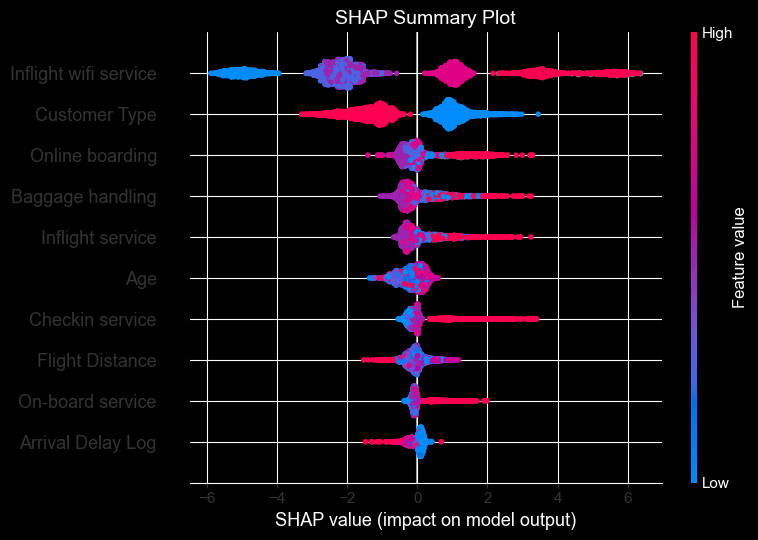

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Business_travel_Eco_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

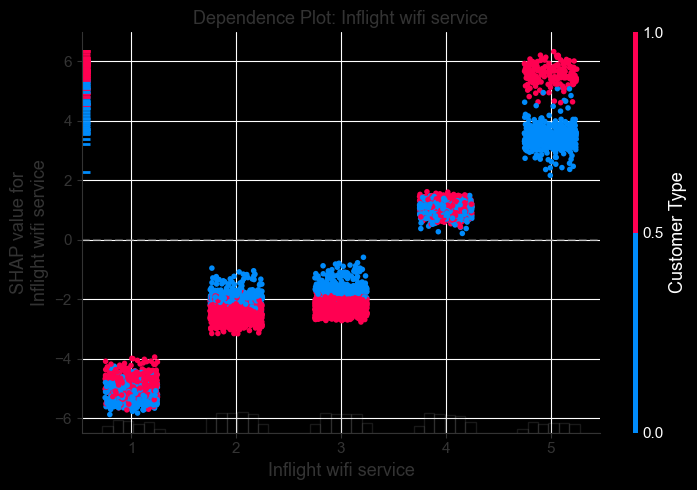

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Business_travel_Eco_Online boarding.png


<Figure size 800x500 with 0 Axes>

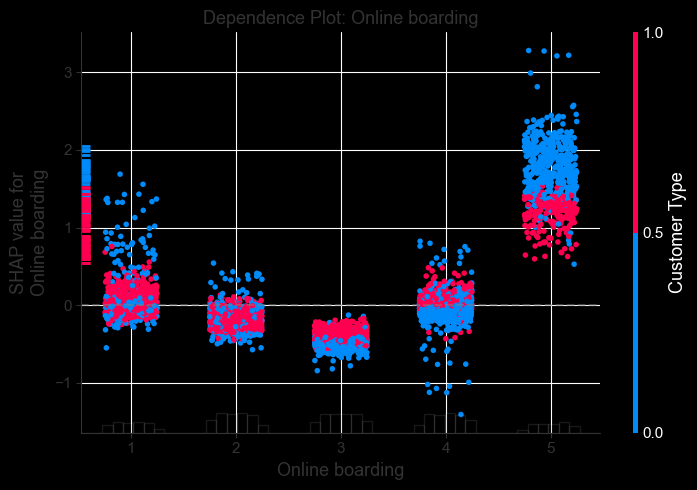


Processing segment: MICRO_Business_travel_Eco_Plus
   Train shape: (3878, 24)
   Test shape:  (1010, 24)

========== Processing: MICRO_Business_travel_Eco_Plus ==========
   >>> Training XGBoost on 3878 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': np.float64(1.54629021667761), 'subsample': 0.8}
   >>> Best CV F1: 0.9237
   [Saved] Model saved to: artifacts\models\MICRO_Business_travel_Eco_Plus.pkl.pkl
   [Saved] Metrics: artifacts\reports\MICRO_Business_travel_Eco_Plus_metrics.json
   Metrics: {'Accuracy': 0.9535, 'Precision': 0.9483, 'Recall': 0.9315, 'Specificity': np.float64(0.9675), 'F1-Score': 0.9398, 'ROC_AUC': 0.9875}
   Generating plots for MICRO_Business_travel_Eco_Plus...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MICRO_Business_travel_Eco_Plus.png


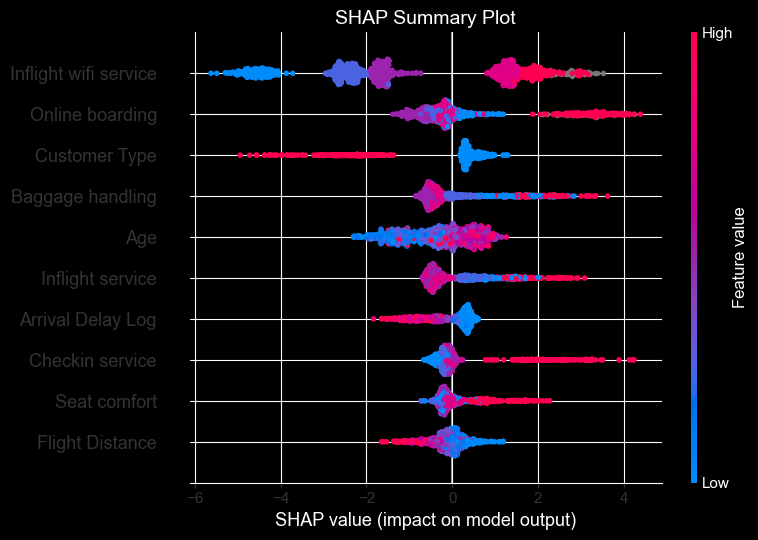

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Business_travel_Eco_Plus_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

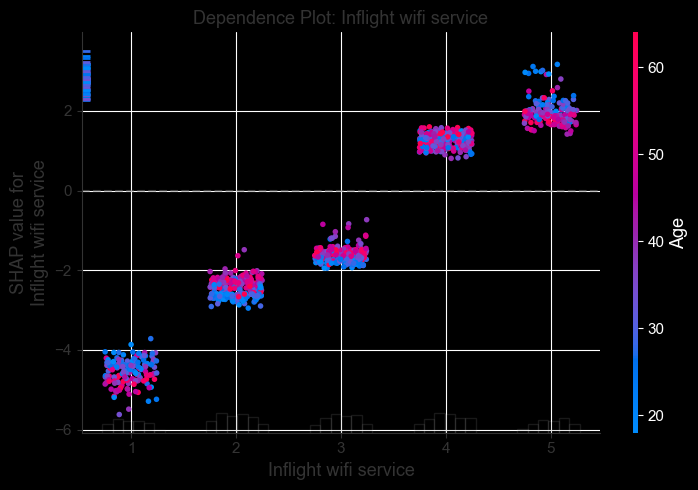

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Business_travel_Eco_Plus_Online boarding.png


<Figure size 800x500 with 0 Axes>

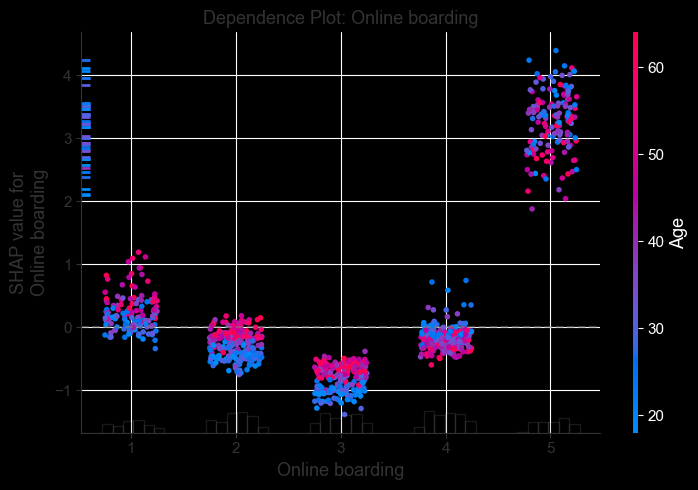


Processing segment: MICRO_Business_travel_Business
   Train shape: (47475, 24)
   Test shape:  (11972, 24)

========== Processing: MICRO_Business_travel_Business ==========
   >>> Training XGBoost on 47475 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.8}
   >>> Best CV F1: 0.9873
   [Saved] Model saved to: artifacts\models\MICRO_Business_travel_Business.pkl.pkl
   [Saved] Metrics: artifacts\reports\MICRO_Business_travel_Business_metrics.json
   Metrics: {'Accuracy': 0.9791, 'Precision': 0.9841, 'Recall': 0.987, 'Specificity': np.float64(0.9587), 'F1-Score': 0.9855, 'ROC_AUC': 0.998}
   Generating plots for MICRO_Business_travel_Business...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MICRO_Business_travel_Business.png


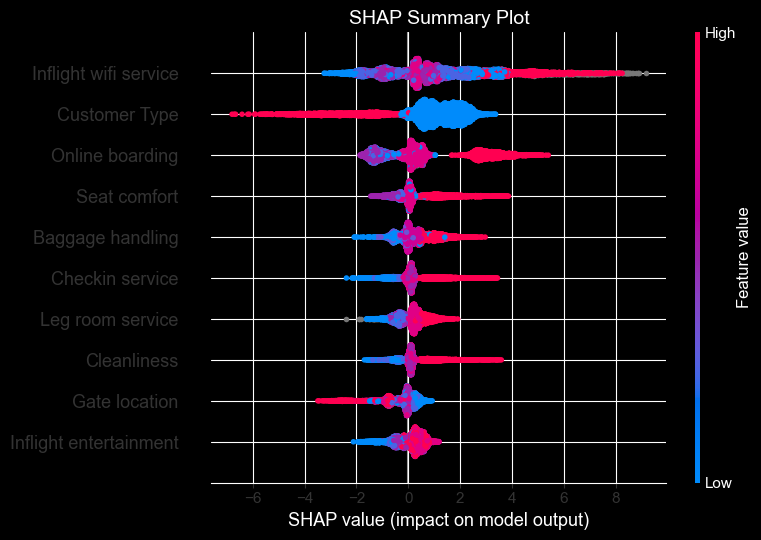

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Business_travel_Business_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

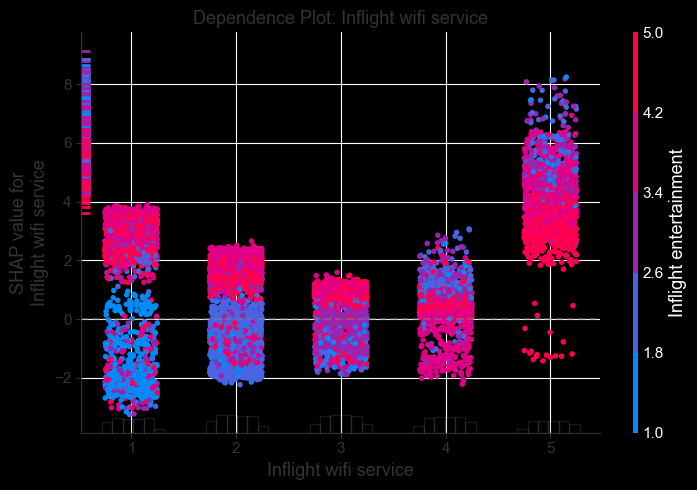

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Business_travel_Business_Online boarding.png


<Figure size 800x500 with 0 Axes>

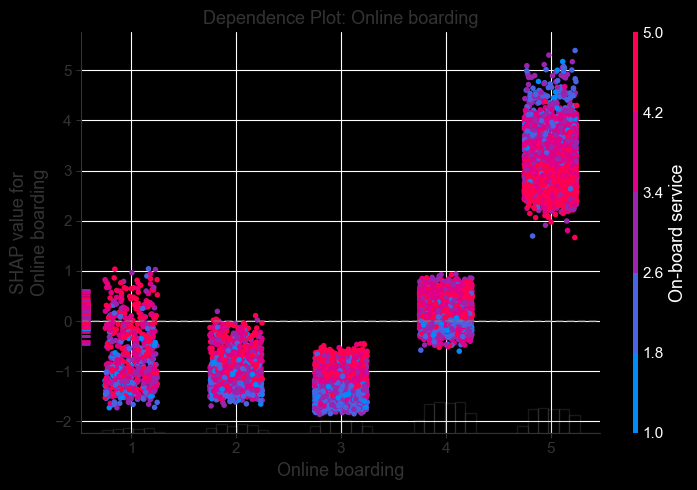


Processing segment: MICRO_Personal_Travel_Eco
   Train shape: (26446, 24)
   Test shape:  (6507, 24)

========== Processing: MICRO_Personal_Travel_Eco ==========
   >>> Training XGBoost on 26446 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1.0, 'subsample': 0.8}
   >>> Best CV F1: 0.7486
   [Saved] Model saved to: artifacts\models\MICRO_Personal_Travel_Eco.pkl.pkl
   [Saved] Metrics: artifacts\reports\MICRO_Personal_Travel_Eco_metrics.json
   Metrics: {'Accuracy': 0.957, 'Precision': 1.0, 'Recall': 0.5783, 'Specificity': np.float64(1.0), 'F1-Score': 0.7328, 'ROC_AUC': 0.9784}
   Generating plots for MICRO_Personal_Travel_Eco...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MICRO_Personal_Travel_Eco.png


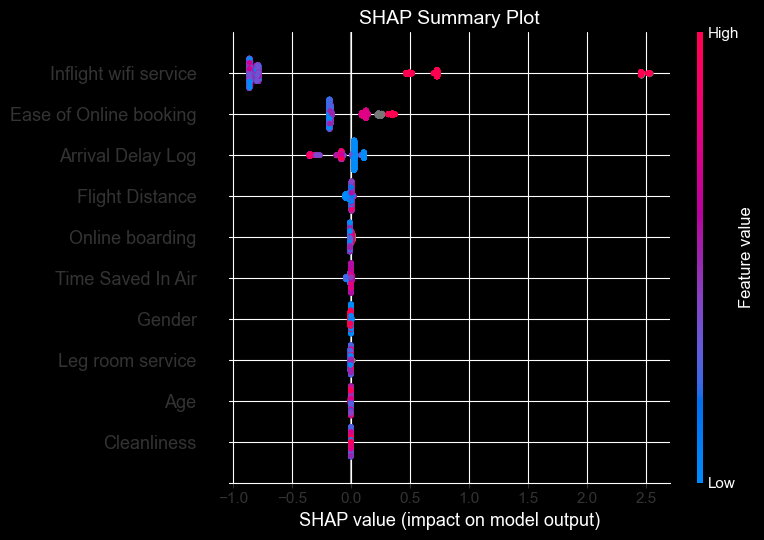

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Eco_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

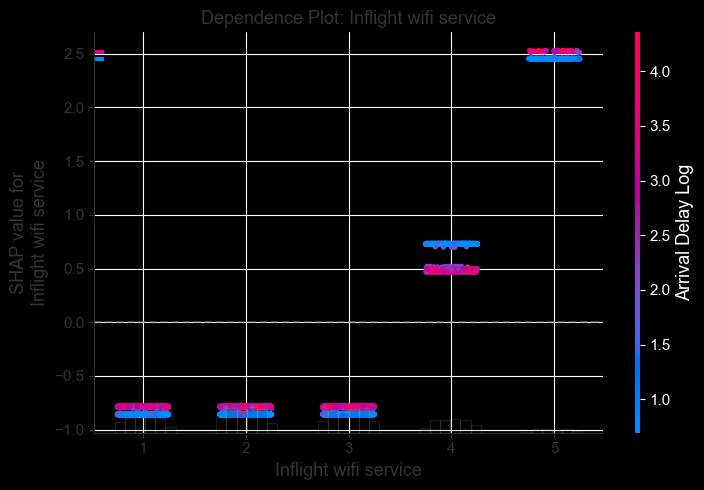

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Eco_Ease of Online booking.png


<Figure size 800x500 with 0 Axes>

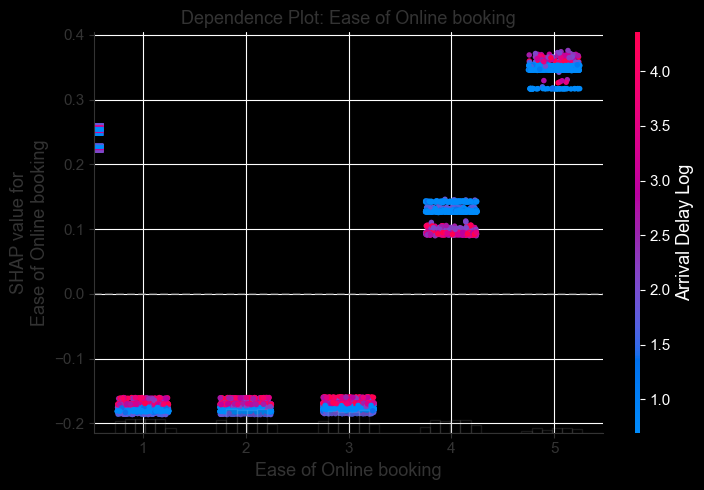

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Eco_Arrival Delay Log.png


<Figure size 800x500 with 0 Axes>

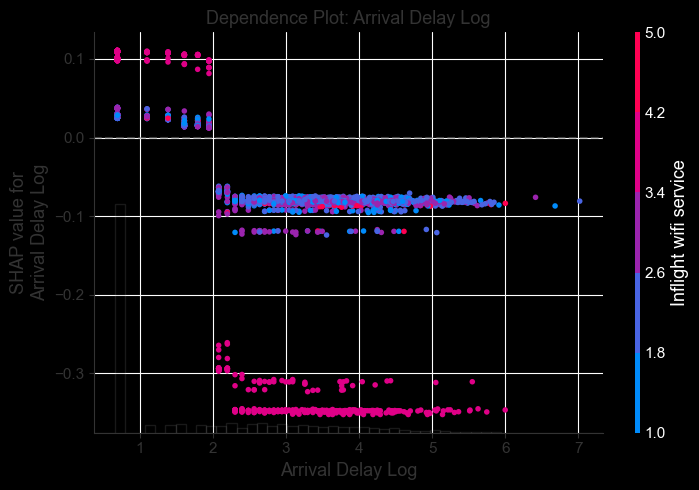


Processing segment: MICRO_Personal_Travel_Eco_Plus
   Train shape: (3597, 24)
   Test shape:  (904, 24)

========== Processing: MICRO_Personal_Travel_Eco_Plus ==========
   >>> Training XGBoost on 3597 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1.0, 'subsample': 0.8}
   >>> Best CV F1: 0.7427
   [Saved] Model saved to: artifacts\models\MICRO_Personal_Travel_Eco_Plus.pkl.pkl
   [Saved] Metrics: artifacts\reports\MICRO_Personal_Travel_Eco_Plus_metrics.json
   Metrics: {'Accuracy': 0.9757, 'Precision': 0.9833, 'Recall': 0.7375, 'Specificity': np.float64(0.9988), 'F1-Score': 0.8429, 'ROC_AUC': 0.9882}
   Generating plots for MICRO_Personal_Travel_Eco_Plus...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MICRO_Personal_Travel_Eco_Plus.png


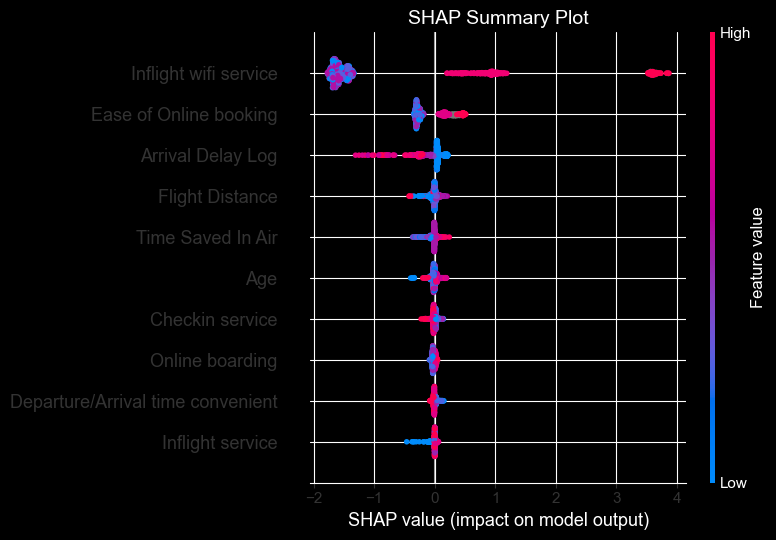

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Eco_Plus_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

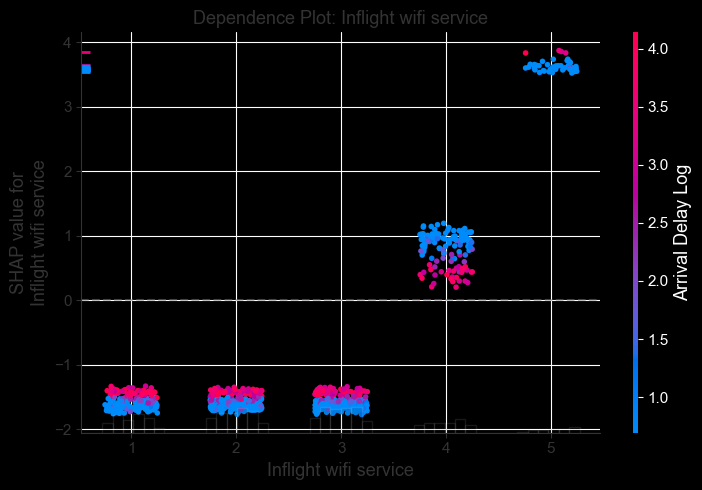

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Eco_Plus_Ease of Online booking.png


<Figure size 800x500 with 0 Axes>

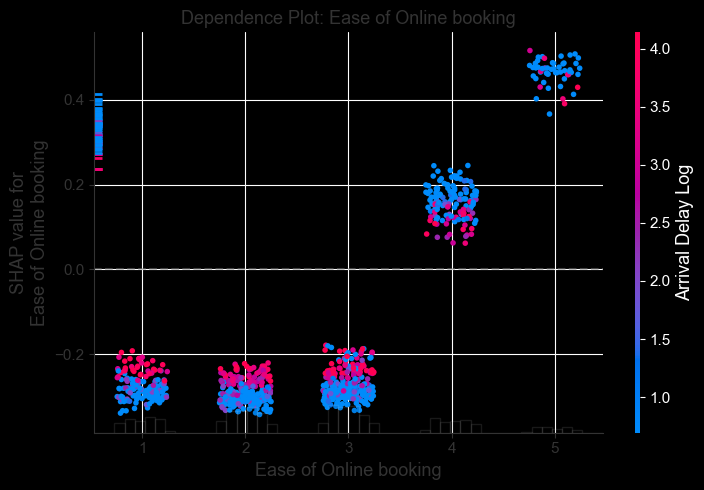

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Eco_Plus_Arrival Delay Log.png


<Figure size 800x500 with 0 Axes>

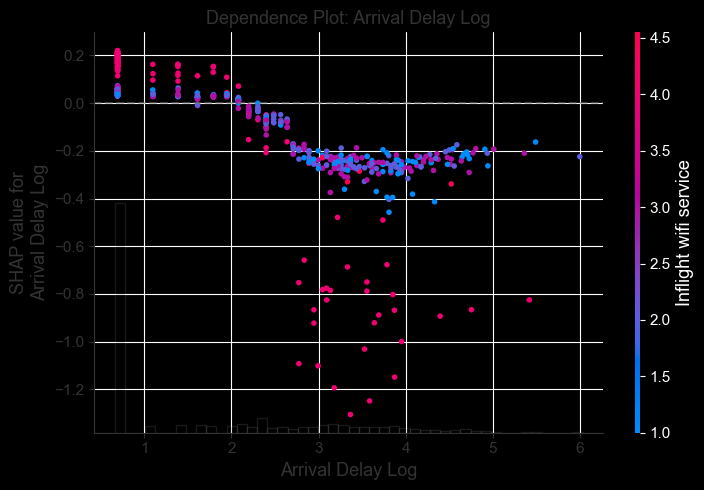


Processing segment: MICRO_Personal_Travel_Business
   Train shape: (2154, 24)
   Test shape:  (515, 24)

========== Processing: MICRO_Personal_Travel_Business ==========
   >>> Training XGBoost on 2154 samples...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
   >>> Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'scale_pos_weight': np.float64(7.252873563218391), 'subsample': 0.8}
   >>> Best CV F1: 0.7115
   [Saved] Model saved to: artifacts\models\MICRO_Personal_Travel_Business.pkl.pkl
   [Saved] Metrics: artifacts\reports\MICRO_Personal_Travel_Business_metrics.json
   Metrics: {'Accuracy': 0.9184, 'Precision': 0.5412, 'Recall': 0.9388, 'Specificity': np.float64(0.9163), 'F1-Score': 0.6866, 'ROC_AUC': 0.9844}
   Generating plots for MICRO_Personal_Travel_Business...
   [Saved] Plot: artifacts\plots\SHAP_Summary_MICRO_Personal_Travel_Business.png


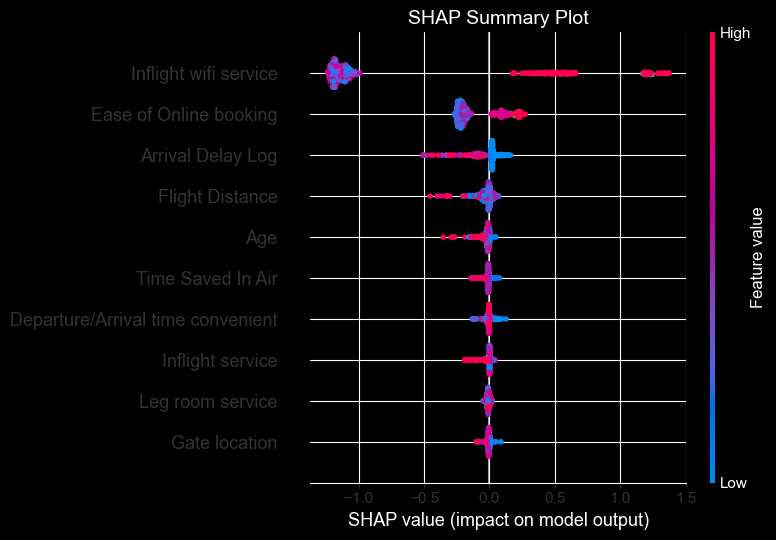

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Business_Inflight wifi service.png


<Figure size 800x500 with 0 Axes>

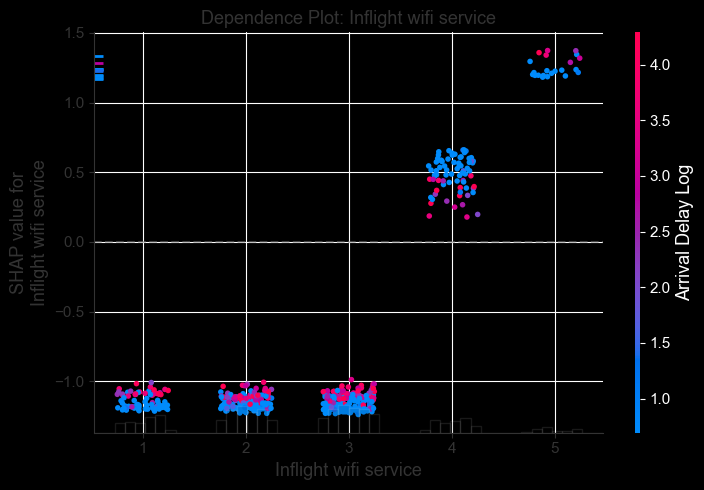

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Business_Ease of Online booking.png


<Figure size 800x500 with 0 Axes>

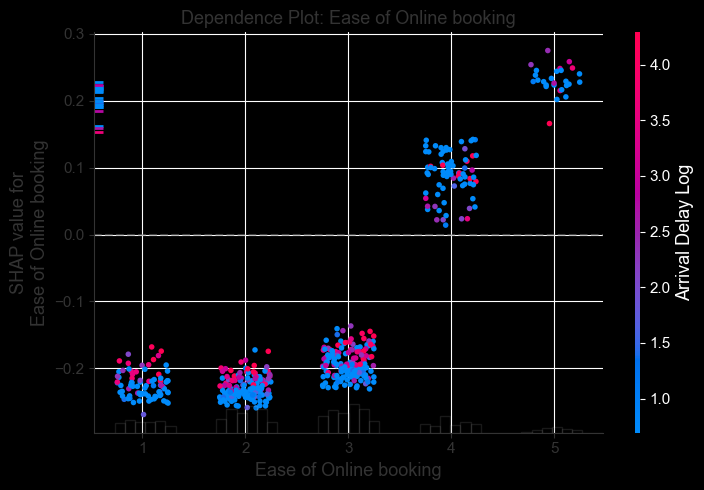

   [Saved] Plot: artifacts\plots\SHAP_Dependence_MICRO_Personal_Travel_Business_Arrival Delay Log.png


<Figure size 800x500 with 0 Axes>

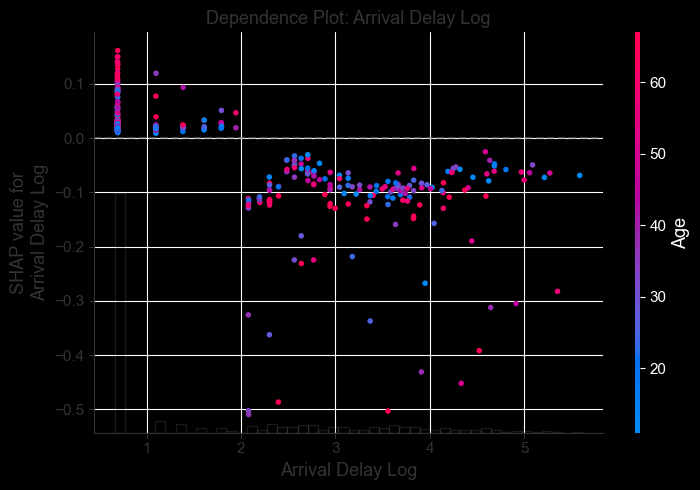


Segmentation finished.


In [49]:
for data in seg_manager.iterate_segments(df_train, df_test):

    metrics = pipeline.run_segment(data)

    if metrics:
        all_metrics[data['name']] = metrics

## Final Comparison & Outcomes

In [50]:
print("\n=== FINAL COMPARISON ===")
df_results = ModelEvaluator.compare_segments(all_metrics)

df_results.to_csv("artifacts/reports/final_comparison.csv")

display(df_results.style.background_gradient(cmap='Greens'))


=== FINAL COMPARISON ===


AttributeError: The '.style' accessor requires jinja2